# Yelp Sentiment EDA
266 Summer 2024
Kevin Kuc, 

The data is publically available here:
*   https://huggingface.co/datasets/Yelp/yelp_review_full


**Data Dictionary**

1.   'text': The review texts are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".
2.   'label': Corresponds to the score associated with the review (between 1 and 5).

## Step 1: Import packages

In [4]:
# scikit-learn
!pip install scikit-learn

# numpy
!pip install numpy

# matplotlib
!pip install matplotlib

# mlxtend
!pip install mlxtend

# seaborn
!pip install seaborn

# statsmodels
!pip install statsmodels

# tensorflow
!pip install tensorflow

# keras (part of TensorFlow)
# Note: Keras is already included in TensorFlow, so you don't need to install it separately
# pip install keras


  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/f9/4b/c035ce6771dd56283cd587e941054ebb38a14868729e28a0f7c6c9ff9ebd/scikit_learn-1.5.0-cp312-cp312-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for scipy>=1.6.0 from https://files.pythonhosted.org/packages/dc/5a/2043a3bde1443d94014aaa41e0b50c39d046dda8360abd3b2a1d3f79907d/scipy-1.13.1-cp312-cp312-macosx_12_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 849.4 kB/s eta 0:00:00 0:00:01
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e2140cafcaa2bef0759a00b7b70104dcfe2fb51/joblib-1.4.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/4b/2c/ffbf7a134b9ab11a67b0cf0726453cedd9c5043a4fe7a35d1cefa9a1bcfb/threadpoolctl-3.5.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [11]:
import pandas as pd
import numpy as np
import csv
import copy
from datasets import load_dataset

# data preprocessing
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
from numpy.random.mtrand import binomial
import random

# exploratory analysis
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image

# model fit
import statsmodels.api as sm
#import tensorflow as tf
#from tensorflow import keras
#from keras import metrics
#from tensorflow.keras import initializers


# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# These commands below set some options for pandas and to have matplotlib show the charts in the notebook
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None  # default='warn'

## Step 2: Read data

In [9]:
dataset = load_dataset('yelp_review_full')
df = dataset['train'].to_pandas()
# print shape of df
print(
    'Shape of data: ',
    df.shape
)

Generating test split: 100%|██████████| 50000/50000 [00:00<00:00, 747184.28 examples/s]


Shape of data:  {'train': (650000, 2), 'test': (50000, 2)}


In [18]:
df.head(10)

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...
5,4,Top notch doctor in a top notch practice. Can'...
6,4,Dr. Eric Goldberg is a fantastic doctor who ha...
7,0,I'm writing this review to give you a heads up...
8,1,Wing sauce is like water. Pretty much a lot of...
9,2,Decent range somewhat close to the city. The ...


In [20]:
# Randomly sample 50,000 entries
sampled_df = df.sample(n=50000, random_state=42)

In [22]:
# Check null values
print(sampled_df.isnull().sum().sort_values(ascending = False)) # Check nulls

# Check column known to contain nulls for coding
sampled_df.label.unique()

label    0
text     0
dtype: int64


array([0, 1, 2, 4, 3])

## Step 3: Data preprocessing


#### Step 3.1: Create outcome variable

Multi-class

In [ ]:
## define outcome variable ##
#############################
init_df['readmitted'].unique()

readmit_dict = {'NO': 0,'<30': 1,'>30': 2}

init_df["readmit_ordinal"] = init_df.readmitted.map(readmit_dict)


Binary

In [ ]:
## define outcome variable ##
#############################
init_df['readmitted'].unique()

readmit_dict = {'NO': 0,'<30': 1,'>30': 1}

init_df["readmit_binary"] = init_df.readmitted.map(readmit_dict)

In [ ]:
init_df["readmit_binary"].unique

<bound method Series.unique of 0         0
1         1
2         0
3         0
4         0
         ..
101761    1
101762    0
101763    0
101764    0
101765    0
Name: readmit_binary, Length: 101766, dtype: int64>

#### Step 3.2: Drop features

In [ ]:
print('Shape of data (before dropping columns): ', init_df.shape)

# Drop payer code medical speciality, & weight
init_df = init_df.drop(columns=['payer_code', 'medical_specialty', 'weight'])

print('Shape of data (after dropping columns): ', init_df.shape)
init_df.head(10)

Shape of data (before dropping columns):  (101766, 52)
Shape of data (after dropping columns):  (101766, 49)


,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmit_ordinal,readmit_binary
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0,0
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,2,1
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,0,0
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,0,0
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,0,0
5,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,31,6,16,0,0,0,414,411,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,2,1
6,55842,84259809,Caucasian,Male,[60-70),3,1,2,4,70,1,21,0,0,0,414,411,V45,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,0,0
7,63768,114882984,Caucasian,Male,[70-80),1,1,7,5,73,0,12,0,0,0,428,492,250,8,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,>30,2,1
8,12522,48330783,Caucasian,Female,[80-90),2,1,4,13,68,2,28,0,0,0,398,427,38,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,0,0
9,15738,63555939,Caucasian,Female,[90-100),3,3,4,12,33,3,18,0,0,0,434,198,486,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,0,0


#### Step 3.3: Add features

In [ ]:
## create one-hot-encodings ##
##############################
init_df.race.unique()

init_df = pd.get_dummies(init_df,prefix=["race", "gen", "admissionId","mxGluSrm", "a1c", "met",
                                        "rep", "nat", "chlor", "glim", "aceto", "glip", "gly", "tolbu", "pio", "ros", "acar", "mig", "trog", "tolaz",
                                        "exa", "cito", "insul", "glyMet", "glipmet", "glimpio", "metros", "metpio", "change", "diabmed"],
                        columns=["race", "gender", "admission_type_id","max_glu_serum", "A1Cresult","metformin", "repaglinide", "nateglinide", "chlorpropamide",
                                 "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose",
                                 "miglitol","troglitazone", "tolazamide", "examide", "citoglipton", "insulin", "glyburide-metformin",
                                 "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone",
                                 "change", "diabetesMed"])

In [ ]:
# convert to lower case
init_df.columns = init_df.columns.str.lower()

print('Shape of data: ', init_df.shape)
init_df.head(30)

Shape of data:  (101766, 119)


,encounter_id,patient_nbr,age,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,readmitted,readmit_ordinal,readmit_binary,race_?,race_africanamerican,race_asian,race_caucasian,race_hispanic,race_other,gen_female,gen_male,gen_unknown/invalid,admissionid_1,admissionid_2,admissionid_3,admissionid_4,admissionid_5,admissionid_6,admissionid_7,admissionid_8,mxglusrm_>200,mxglusrm_>300,mxglusrm_none,mxglusrm_norm,a1c_>7,a1c_>8,a1c_none,a1c_norm,met_down,met_no,met_steady,met_up,rep_down,rep_no,rep_steady,rep_up,nat_down,nat_no,nat_steady,nat_up,chlor_down,chlor_no,chlor_steady,chlor_up,glim_down,glim_no,glim_steady,glim_up,aceto_no,aceto_steady,glip_down,glip_no,glip_steady,glip_up,gly_down,gly_no,gly_steady,gly_up,tolbu_no,tolbu_steady,pio_down,pio_no,pio_steady,pio_up,ros_down,ros_no,ros_steady,ros_up,acar_down,acar_no,acar_steady,acar_up,mig_down,mig_no,mig_steady,mig_up,trog_no,trog_steady,tolaz_no,tolaz_steady,tolaz_up,exa_no,cito_no,insul_down,insul_no,insul_steady,insul_up,glymet_down,glymet_no,glymet_steady,glymet_up,glipmet_no,glipmet_steady,glimpio_no,glimpio_steady,metros_no,metros_steady,metpio_no,metpio_steady,change_ch,change_no,diabmed_no,diabmed_yes
0,2278392,8222157,[0-10),25,1,1,41,0,1,0,0,0,250.83,?,?,1,NO,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0
1,149190,55629189,[10-20),1,7,3,59,0,18,0,0,0,276,250.01,255,9,>30,2,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1
2,64410,86047875,[20-30),1,7,2,11,5,13,2,0,1,648,250,V27,6,NO,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1
3,500364,82442376,[30-40),1,7,2,44,1,16,0,0,0,8,250.43,403,7,NO,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1
4,16680,42519267,[40-50),1,7,1,51,0,8,0,0,0,197,157,250,5,NO,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1
5,35754,82637451,[50-60),1,2,3,31,6,16,0,0,0,414,411,250,9,>30,2,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1
6,55842,84259809,[60-70),1,2,4,70,1,21,0,0,0,414,411,V45,7,NO,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1
7,63768,114882984,[70-80),1,7,5,73,0,12,0,0,0,428,492,250,8,>30,2,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1
8,12522,48330783,[80-90),1,4,13,68,2,28,0,0,0,398,427,38,8,NO,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1
9,15738,63555939,[90-100),3,4,12,33,3,18,0,0,0,434,198,486,8,NO,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1


In [ ]:
## create ordered age variable ##
#################################
init_df['age'].unique()

age_dict = {'[0-10)': 1,'[10-20)': 2,'[20-30)': 3, '[30-40)': 4, '[40-50)': 5, '[50-60)': 6, '[60-70)': 7,
            '[70-80)': 8, '[80-90)': 9, '[90-100)': 10}

init_df["age_ordinal"] = init_df.age.map(age_dict)

init_df.head(10)


,encounter_id,patient_nbr,age,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,readmitted,readmit_ordinal,readmit_binary,race_?,race_africanamerican,race_asian,race_caucasian,race_hispanic,race_other,gen_female,gen_male,gen_unknown/invalid,admissionid_1,admissionid_2,admissionid_3,admissionid_4,admissionid_5,admissionid_6,admissionid_7,admissionid_8,mxglusrm_>200,mxglusrm_>300,mxglusrm_none,mxglusrm_norm,a1c_>7,a1c_>8,a1c_none,a1c_norm,met_down,met_no,met_steady,met_up,rep_down,rep_no,rep_steady,rep_up,nat_down,nat_no,nat_steady,nat_up,chlor_down,chlor_no,chlor_steady,chlor_up,glim_down,glim_no,glim_steady,glim_up,aceto_no,aceto_steady,glip_down,glip_no,glip_steady,glip_up,gly_down,gly_no,gly_steady,gly_up,tolbu_no,tolbu_steady,pio_down,pio_no,pio_steady,pio_up,ros_down,ros_no,ros_steady,ros_up,acar_down,acar_no,acar_steady,acar_up,mig_down,mig_no,mig_steady,mig_up,trog_no,trog_steady,tolaz_no,tolaz_steady,tolaz_up,exa_no,cito_no,insul_down,insul_no,insul_steady,insul_up,glymet_down,glymet_no,glymet_steady,glymet_up,glipmet_no,glipmet_steady,glimpio_no,glimpio_steady,metros_no,metros_steady,metpio_no,metpio_steady,change_ch,change_no,diabmed_no,diabmed_yes,age_ordinal
0,2278392,8222157,[0-10),25,1,1,41,0,1,0,0,0,250.83,?,?,1,NO,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,1
1,149190,55629189,[10-20),1,7,3,59,0,18,0,0,0,276,250.01,255,9,>30,2,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,2
2,64410,86047875,[20-30),1,7,2,11,5,13,2,0,1,648,250,V27,6,NO,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,3
3,500364,82442376,[30-40),1,7,2,44,1,16,0,0,0,8,250.43,403,7,NO,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,4
4,16680,42519267,[40-50),1,7,1,51,0,8,0,0,0,197,157,250,5,NO,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,5
5,35754,82637451,[50-60),1,2,3,31,6,16,0,0,0,414,411,250,9,>30,2,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,6
6,55842,84259809,[60-70),1,2,4,70,1,21,0,0,0,414,411,V45,7,NO,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,7
7,63768,114882984,[70-80),1,7,5,73,0,12,0,0,0,428,492,250,8,>30,2,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,8
8,12522,48330783,[80-90),1,4,13,68,2,28,0,0,0,398,427,38,8,NO,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,9
9,15738,63555939,[90-100),3,4,12,33,3,18,0,0,0,434,198,486,8,NO,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,

#### Step 3.4: Clean features

In [ ]:
## drop observations ##
#######################

# Recode ? as NaN
init_df = init_df.replace('?', np.NaN)

# Recheck NAs
init_df.isnull().sum().sort_values(ascending = False) # Check nulls

# Keep old dataframe for comparison
original_data = init_df

# Drop missing from diag_1:diag_3
init_df.dropna(subset=['diag_1', 'diag_2', 'diag_3'], inplace=True)

print("After removing NAs in diagnosis 1 - 3:", init_df.shape)

After removing NAs in diagnosis 1 - 3: (100244, 120)


**Diagnosis 1**

In [ ]:
# Create new dataframe with only numerical codes
diag1_num = init_df[~init_df['diag_1'].str.contains(r'E|V')]

# Convert to float & strip off decimal point
diag1_num['diag_1'] = diag1_num['diag_1'].astype(float)

diag1_num['diag_1'] = np.floor(diag1_num['diag_1'])

# Convert to integer
diag1_num['diag_1'] = diag1_num['diag_1'].astype(int)

# Create new dataframe with alphanumerical codes
diag1_char = init_df[init_df['diag_1'].str.contains(r'E|V')]

In [ ]:
print(diag1_num.shape)
print(diag1_char.shape)


(98606, 120)
(1638, 120)


In [ ]:
# Recode numerical diagnosis 1 at first level

# List of conditions
conditions = [
      (diag1_num['diag_1'] >= 1) & (diag1_num['diag_1'] <= 139),
      (diag1_num['diag_1'] >= 140) & (diag1_num['diag_1'] <= 239),
      (diag1_num['diag_1'] >= 240) & (diag1_num['diag_1'] <= 279),
      (diag1_num['diag_1'] >= 280) & (diag1_num['diag_1'] <= 289),
      (diag1_num['diag_1'] >= 290) & (diag1_num['diag_1'] <= 319),
      (diag1_num['diag_1'] >= 320) & (diag1_num['diag_1'] <= 389),
      (diag1_num['diag_1'] >= 390) & (diag1_num['diag_1'] <= 459),
      (diag1_num['diag_1'] >= 460) & (diag1_num['diag_1'] <= 519),
      (diag1_num['diag_1'] >= 520) & (diag1_num['diag_1'] <= 579),
      (diag1_num['diag_1'] >= 580) & (diag1_num['diag_1'] <= 629),
      (diag1_num['diag_1'] >= 630) & (diag1_num['diag_1'] <= 679),
      (diag1_num['diag_1'] >= 680) & (diag1_num['diag_1'] <= 709),
      (diag1_num['diag_1'] >= 710) & (diag1_num['diag_1'] <= 739),
      (diag1_num['diag_1'] >= 740) & (diag1_num['diag_1'] <= 759),
      (diag1_num['diag_1'] >= 760) & (diag1_num['diag_1'] <= 779),
      (diag1_num['diag_1'] >= 780) & (diag1_num['diag_1'] <= 799),
      (diag1_num['diag_1'] >= 800) & (diag1_num['diag_1'] <= 999)
]

# List of values to return
choices  = [
      "infect_parasitic_disease"
    , "neoplasms"
    , "metab_disease_immune"
    , "blood_disease"
    , "mental_disorder"
    , "nervous_disease"
    , "circ_disease"
    , "resp_disease"
    , "digest_disease"
    , "gen_urine_disease"
    , "preg_birth_comp"
    , "skin_disease"
    , "msk_disease"
    , "congen_anom"
    , "perinatal_cond"
    , "symptoms_etc"
    , "injury_poison"
]

# create a new column based on the conditions
diag1_num["diag1_lvl1"] = np.select(conditions, choices, "ERROR")

diag1_num["diag1_lvl1"].unique()


array(['metab_disease_immune', 'preg_birth_comp',
       'infect_parasitic_disease', 'neoplasms', 'circ_disease',
       'resp_disease', 'injury_poison', 'skin_disease', 'msk_disease',
       'digest_disease', 'symptoms_etc', 'gen_urine_disease',
       'mental_disorder', 'nervous_disease', 'blood_disease',
       'congen_anom'], dtype=object)

In [ ]:
# Recode numerical diagnosis 1 at second level
# List of conditions
conditions = [
      (diag1_num['diag_1'] >= 1) & (diag1_num['diag_1'] <= 9),
      (diag1_num['diag_1'] >= 10) & (diag1_num['diag_1'] <= 18),
      (diag1_num['diag_1'] >= 20) & (diag1_num['diag_1'] <= 27),
      (diag1_num['diag_1'] >= 30) & (diag1_num['diag_1'] <= 41),
      (diag1_num['diag_1'] >= 42) & (diag1_num['diag_1'] <= 42),
      (diag1_num['diag_1'] >= 45) & (diag1_num['diag_1'] <= 49),
      (diag1_num['diag_1'] >= 50) & (diag1_num['diag_1'] <= 59),
      (diag1_num['diag_1'] >= 60) & (diag1_num['diag_1'] <= 66),
      (diag1_num['diag_1'] >= 70) & (diag1_num['diag_1'] <= 79),
      (diag1_num['diag_1'] >= 80) & (diag1_num['diag_1'] <= 88),
      (diag1_num['diag_1'] >= 90) & (diag1_num['diag_1'] <= 99),
      (diag1_num['diag_1'] >= 100) & (diag1_num['diag_1'] <= 104),
      (diag1_num['diag_1'] >= 110) & (diag1_num['diag_1'] <= 118),
      (diag1_num['diag_1'] >= 120) & (diag1_num['diag_1'] <= 129),
      (diag1_num['diag_1'] >= 130) & (diag1_num['diag_1'] <= 136),
      (diag1_num['diag_1'] >= 137) & (diag1_num['diag_1'] <= 139),
      (diag1_num['diag_1'] >= 140) & (diag1_num['diag_1'] <= 149),
      (diag1_num['diag_1'] >= 150) & (diag1_num['diag_1'] <= 159),
      (diag1_num['diag_1'] >= 160) & (diag1_num['diag_1'] <= 165),
      (diag1_num['diag_1'] >= 170) & (diag1_num['diag_1'] <= 176),
      (diag1_num['diag_1'] >= 179) & (diag1_num['diag_1'] <= 189),
      (diag1_num['diag_1'] >= 190) & (diag1_num['diag_1'] <= 199),
      (diag1_num['diag_1'] >= 200) & (diag1_num['diag_1'] <= 208),
      (diag1_num['diag_1'] == 209),
      (diag1_num['diag_1'] >= 210) & (diag1_num['diag_1'] <= 229),
      (diag1_num['diag_1'] >= 230) & (diag1_num['diag_1'] <= 234),
      (diag1_num['diag_1'] >= 235) & (diag1_num['diag_1'] <= 238),
      (diag1_num['diag_1'] >= 239) & (diag1_num['diag_1'] <= 239),
      (diag1_num['diag_1'] >= 240) & (diag1_num['diag_1'] <= 246),
      (diag1_num['diag_1'] >= 249) & (diag1_num['diag_1'] <= 259),
      (diag1_num['diag_1'] >= 260) & (diag1_num['diag_1'] <= 269),
      (diag1_num['diag_1'] >= 270) & (diag1_num['diag_1'] <= 279),
      (diag1_num['diag_1'] == 280),
      (diag1_num['diag_1'] == 281),
      (diag1_num['diag_1'] == 282),
      (diag1_num['diag_1'] == 283),
      (diag1_num['diag_1'] == 284),
      (diag1_num['diag_1'] == 285),
      (diag1_num['diag_1'] == 286),
      (diag1_num['diag_1'] == 287),
      (diag1_num['diag_1'] == 288),
      (diag1_num['diag_1'] == 289),
      (diag1_num['diag_1'] >= 290) & (diag1_num['diag_1'] <= 299),
      (diag1_num['diag_1'] >= 300) & (diag1_num['diag_1'] <= 316),
      (diag1_num['diag_1'] >= 317) & (diag1_num['diag_1'] <= 319),
      (diag1_num['diag_1'] >= 320) & (diag1_num['diag_1'] <= 326),
      (diag1_num['diag_1'] == 327),
      (diag1_num['diag_1'] >= 330) & (diag1_num['diag_1'] <= 337),
      (diag1_num['diag_1'] == 338),
      (diag1_num['diag_1'] == 339),
      (diag1_num['diag_1'] >= 340) & (diag1_num['diag_1'] <= 349),
      (diag1_num['diag_1'] >= 350) & (diag1_num['diag_1'] <= 359),
      (diag1_num['diag_1'] >= 360) & (diag1_num['diag_1'] <= 379),
      (diag1_num['diag_1'] >= 380) & (diag1_num['diag_1'] <= 389),
      (diag1_num['diag_1'] >= 390) & (diag1_num['diag_1'] <= 392),
      (diag1_num['diag_1'] >= 393) & (diag1_num['diag_1'] <= 398),
      (diag1_num['diag_1'] >= 401) & (diag1_num['diag_1'] <= 405),
      (diag1_num['diag_1'] >= 410) & (diag1_num['diag_1'] <= 414),
      (diag1_num['diag_1'] >= 415) & (diag1_num['diag_1'] <= 417),
      (diag1_num['diag_1'] >= 420) & (diag1_num['diag_1'] <= 429),
      (diag1_num['diag_1'] >= 430) & (diag1_num['diag_1'] <= 438),
      (diag1_num['diag_1'] >= 440) & (diag1_num['diag_1'] <= 449),
      (diag1_num['diag_1'] >= 451) & (diag1_num['diag_1'] <= 459),
      (diag1_num['diag_1'] >= 460) & (diag1_num['diag_1'] <= 466),
      (diag1_num['diag_1'] >= 470) & (diag1_num['diag_1'] <= 478),
      (diag1_num['diag_1'] >= 480) & (diag1_num['diag_1'] <= 488),
      (diag1_num['diag_1'] >= 490) & (diag1_num['diag_1'] <= 496),
      (diag1_num['diag_1'] >= 500) & (diag1_num['diag_1'] <= 508),
      (diag1_num['diag_1'] >= 510) & (diag1_num['diag_1'] <= 519),
      (diag1_num['diag_1'] >= 520) & (diag1_num['diag_1'] <= 529),
      (diag1_num['diag_1'] >= 530) & (diag1_num['diag_1'] <= 539),
      (diag1_num['diag_1'] >= 540) & (diag1_num['diag_1'] <= 549),
      (diag1_num['diag_1'] >= 550) & (diag1_num['diag_1'] <= 553),
      (diag1_num['diag_1'] >= 555) & (diag1_num['diag_1'] <= 558),
      (diag1_num['diag_1'] >= 560) & (diag1_num['diag_1'] <= 569),
      (diag1_num['diag_1'] >= 570) & (diag1_num['diag_1'] <= 579),
      (diag1_num['diag_1'] >= 580) & (diag1_num['diag_1'] <= 589),
      (diag1_num['diag_1'] >= 590) & (diag1_num['diag_1'] <= 599),
      (diag1_num['diag_1'] >= 600) & (diag1_num['diag_1'] <= 608),
      (diag1_num['diag_1'] >= 610) & (diag1_num['diag_1'] <= 612),
      (diag1_num['diag_1'] >= 614) & (diag1_num['diag_1'] <= 616),
      (diag1_num['diag_1'] >= 617) & (diag1_num['diag_1'] <= 629),
      (diag1_num['diag_1'] >= 630) & (diag1_num['diag_1'] <= 633),
      (diag1_num['diag_1'] >= 634) & (diag1_num['diag_1'] <= 639),
      (diag1_num['diag_1'] >= 640) & (diag1_num['diag_1'] <= 649),
      (diag1_num['diag_1'] >= 650) & (diag1_num['diag_1'] <= 659),
      (diag1_num['diag_1'] >= 660) & (diag1_num['diag_1'] <= 669),
      (diag1_num['diag_1'] >= 670) & (diag1_num['diag_1'] <= 677),
      (diag1_num['diag_1'] >= 678) & (diag1_num['diag_1'] <= 679),
      (diag1_num['diag_1'] >= 680) & (diag1_num['diag_1'] <= 686),
      (diag1_num['diag_1'] >= 690) & (diag1_num['diag_1'] <= 698),
      (diag1_num['diag_1'] >= 700) & (diag1_num['diag_1'] <= 709),
      (diag1_num['diag_1'] >= 710) & (diag1_num['diag_1'] <= 719),
      (diag1_num['diag_1'] >= 720) & (diag1_num['diag_1'] <= 724),
      (diag1_num['diag_1'] >= 725) & (diag1_num['diag_1'] <= 729),
      (diag1_num['diag_1'] >= 730) & (diag1_num['diag_1'] <= 739),
      (diag1_num['diag_1'] == 740),
      (diag1_num['diag_1'] == 741),
      (diag1_num['diag_1'] == 742),
      (diag1_num['diag_1'] == 743),
      (diag1_num['diag_1'] == 744),
      (diag1_num['diag_1'] == 745),
      (diag1_num['diag_1'] == 746),
      (diag1_num['diag_1'] == 747),
      (diag1_num['diag_1'] == 748),
      (diag1_num['diag_1'] == 749),
      (diag1_num['diag_1'] == 750),
      (diag1_num['diag_1'] == 751),
      (diag1_num['diag_1'] == 752),
      (diag1_num['diag_1'] == 753),
      (diag1_num['diag_1'] == 754),
      (diag1_num['diag_1'] == 755),
      (diag1_num['diag_1'] == 756),
      (diag1_num['diag_1'] == 757),
      (diag1_num['diag_1'] == 758),
      (diag1_num['diag_1'] == 759),
      (diag1_num['diag_1'] >= 780) & (diag1_num['diag_1'] <= 789),
      (diag1_num['diag_1'] >= 790) & (diag1_num['diag_1'] <= 796),
      (diag1_num['diag_1'] >= 797) & (diag1_num['diag_1'] <= 799),
      (diag1_num['diag_1'] >= 800) & (diag1_num['diag_1'] <= 829),
      (diag1_num['diag_1'] >= 830) & (diag1_num['diag_1'] <= 839),
      (diag1_num['diag_1'] >= 840) & (diag1_num['diag_1'] <= 848),
      (diag1_num['diag_1'] >= 850) & (diag1_num['diag_1'] <= 854),
      (diag1_num['diag_1'] >= 860) & (diag1_num['diag_1'] <= 869),
      (diag1_num['diag_1'] >= 870) & (diag1_num['diag_1'] <= 897),
      (diag1_num['diag_1'] >= 900) & (diag1_num['diag_1'] <= 904),
      (diag1_num['diag_1'] >= 905) & (diag1_num['diag_1'] <= 909),
      (diag1_num['diag_1'] >= 910) & (diag1_num['diag_1'] <= 919),
      (diag1_num['diag_1'] >= 920) & (diag1_num['diag_1'] <= 924),
      (diag1_num['diag_1'] >= 925) & (diag1_num['diag_1'] <= 929),
      (diag1_num['diag_1'] >= 930) & (diag1_num['diag_1'] <= 939),
      (diag1_num['diag_1'] >= 940) & (diag1_num['diag_1'] <= 949),
      (diag1_num['diag_1'] >= 950) & (diag1_num['diag_1'] <= 957),
      (diag1_num['diag_1'] >= 958) & (diag1_num['diag_1'] <= 959),
      (diag1_num['diag_1'] >= 960) & (diag1_num['diag_1'] <= 979),
      (diag1_num['diag_1'] >= 980) & (diag1_num['diag_1'] <= 989),
      (diag1_num['diag_1'] >= 990) & (diag1_num['diag_1'] <= 995),
      (diag1_num['diag_1'] >= 996) & (diag1_num['diag_1'] <= 999)
]

# List of values to return
choices  = [
      "intestine_infect"
    , "tb"
    , "zoonotic_bacterial"
    , "other_bacterial"
    , "hiv"
    , "polio_prion_cns"
    , "viral_exanthem"
    , "artho_viral"
    , "viral_oth"
    , "ricketts_oth"
    , "syphilis_venereal"
    , "spiro_oth"
    , "mycoses"
    , "helmin"
    , "infect_parasit_oth"
    , "late_effects"
    , "neo_lip_oral"
    , "neo_digest"
    , "neo_resp"
    , "neo_bone_skin"
    , "neo_gen_urine"
    , "neo_oth"
    , "neo_lymph"
    , "neuroend_tumor"
    , "neo_benign"
    , "carcinoma_situ"
    , "neo_uncertain"
    , "neo_unspecified"
    , "thyroid_disorder"
    , "end_disease_oth"
    , "nutrition_def"
    , "metab_immune_oth"
    , "iron_def_anemia"
    , "oth_def_anemia"
    , "hemolytic_hereditary"
    , "hemolytic_acquired"
    , "aplastic_anemia"
    , "oth_anemia"
    , "coag_defect"
    , "purpura_hemorr_oth"
    , "wbc_disease"
    , "blood_disease_oth"
    , "psychoses"
    , "nonpsychotic"
    , "intellectual_disab"
    , "inflammatory_cns"
    , "sleep_disorder"
    , "hereditary_cns"
    , "pain"
    , "headache_oth"
    , "oth_disorder_cns"
    , "pns_disorder"
    , "eye_adnexa_disorder"
    , "ear_mast_disease"
    , "rheum_fever"
    , "rheum_hd"
    , "hypertens_disease"
    , "ischemic_hd"
    , "pulmonary_circ_disease"
    , "hd_oth"
    , "cerebrovasc_disease"
    , "arteries_disease"
    , "vein_lymp_disease"
    , "resp_infect"
    , "up_resp_disease_oth"
    , "pneumonia_flu"
    , "copd_etc"
    , "penumoconoises_oth"
    , "resp_disease_oth"
    , "oral_cav_jaw_disease"
    , "stomach_etc_disease"
    , "appendicitis"
    , "hernia"
    , "enter_colitis_noninfect"
    , "intestine_disease_oth"
    , "digest_disease_oth"
    , "nephritis"
    , "urine_disease_oth"
    , "male_gen_disease"
    , "breast_disorder"
    , "fem_pelvic_disease"
    , "fem_gen_disorder_oth"
    , "ectopic_molar_preg"
    , "preg_oth_abort"
    , "preg_comp"
    , "normal_delivery"
    , "labor_comp"
    , "puerperium_comp"
    , "maternal_oth_comp"
    , "skin_infect"
    , "skin_inflam_oth"
    , "skin_disease_oth"
    , "arthropathies"
    , "dorsopathies"
    , "rheumatism"
    , "osteopathies_etc"
    ,"anencephalus"
    , "spina_bifida"
    , "congen_anom_nerv_oth"
    , "congen_anom_eye"
    , "congen_anom_ear_etc"
    , "bc_cardiac_sept_anom"
    , "congen_anom_heart_oth"
    , "congen_anom_circ_oth"
    , "congen_anom_resp"
    , "cleft_palate"
    , "congen_anom_up_aliment"
    , "congen_anom_digest_oth"
    , "congen_anom_gen"
    , "congen_anom_urine"
    , "congen_msk_deform"
    , "congen_anom_limb_oth"
    , "congen_anom_msk_oth"
    , "congen_anom_integument"
    , "chromosome_anom"
    , "congen_anom_oth"
    , "symptoms"
    , "abnormal_find"
    , "m_and_m_unk"
    , "fractures"
    , "dislocation"
    , "sprain_joint"
    , "intracranial_injure"
    , "intern_injure_thorax_etc"
    , "open_wounds"
    , "blood_vessel_injure"
    , "injure_poison_effects"
    , "superficial_injure"
    , "contusion_intact_skin"
    , "crush_injure"
    , "foreign_orifice_effect"
    , "burns"
    , "nerve_spine_injure"
    , "trauma_comp"
    , "poison_drugs_etc"
    , "toxic_nonmed_effects"
    , "unspecified_oth_effects"
    , "surg_med_comp"
]

# create a new column based on the conditions
diag1_num["diag1_lvl2"] = np.select(conditions, choices, "ERROR")

In [ ]:
np.sort(diag1_char['diag_1'].unique())

array(['E909', 'V07', 'V25', 'V26', 'V43', 'V45', 'V51', 'V53', 'V54',
       'V55', 'V56', 'V57', 'V58', 'V60', 'V63', 'V66', 'V67', 'V71'],
      dtype=object)

In [ ]:
# Recode alphanumerical diagnosis 1 at first level

# ICD9 codes starting with E
diag1_charE = diag1_char[diag1_char['diag_1'].str.contains(r'E')]

# Drop E
diag1_charE['diag1'] = diag1_charE['diag_1'].str[1:]

diag1_charE['diag1'] = diag1_charE['diag1'].astype(int)

# List of conditions
conditions = [
      (diag1_charE['diag1'] >= 0) & (diag1_charE['diag1'] <= 999)
]

# List of values to return
choices  = [
      "supp_class_ext_injure_poison"
]

# create a new column based on the conditions
diag1_charE["diag1_lvl1"] = np.select(conditions, choices, "ERROR")

In [ ]:
# Recode alphanumerical diagnosis 1 at first level

# ICD9 codes starting with V
diag1_charV = diag1_char[diag1_char['diag_1'].str.contains(r'V')]

# Drop V
diag1_charV['diag1'] = diag1_charV['diag_1'].str[1:]

diag1_charV['diag1'] = diag1_charV['diag1'].astype(int)

# List of conditions
conditions = [
      (diag1_charV['diag1'] >= 0) & (diag1_charV['diag1'] <= 999)
]

# List of values to return
choices  = [
      "supp_class_factors_health_status"
]

# create a new column based on the conditions
diag1_charV["diag1_lvl1"] = np.select(conditions, choices, "ERROR")

In [ ]:
# Recode alphanumerical diagnosis 1 at second level - codes starting with E

# List of conditions
conditions = [
      (diag1_charE['diag1'] == 0),
      (diag1_charE['diag1'] >= 1) & (diag1_charE['diag1'] <= 30),
      (diag1_charE['diag1'] >= 800) & (diag1_charE['diag1'] <= 848),
      (diag1_charE['diag1'] == 849),
      (diag1_charE['diag1'] >= 850) & (diag1_charE['diag1'] <= 858),
      (diag1_charE['diag1'] >= 860) & (diag1_charE['diag1'] <= 869),
      (diag1_charE['diag1'] >= 870) & (diag1_charE['diag1'] <= 876),
      (diag1_charE['diag1'] >= 878) & (diag1_charE['diag1'] <= 879),
      (diag1_charE['diag1'] >= 880) & (diag1_charE['diag1'] <= 888),
      (diag1_charE['diag1'] >= 890) & (diag1_charE['diag1'] <= 899),
      (diag1_charE['diag1'] >= 900) & (diag1_charE['diag1'] <= 909),
      (diag1_charE['diag1'] >= 910) & (diag1_charE['diag1'] <= 915),
      (diag1_charE['diag1'] >= 916) & (diag1_charE['diag1'] <= 928),
      (diag1_charE['diag1'] == 929),
      (diag1_charE['diag1'] >= 930) & (diag1_charE['diag1'] <= 949),
      (diag1_charE['diag1'] >= 950) & (diag1_charE['diag1'] <= 959),
      (diag1_charE['diag1'] >= 960) & (diag1_charE['diag1'] <= 969),
      (diag1_charE['diag1'] >= 970) & (diag1_charE['diag1'] <= 978),
      (diag1_charE['diag1'] == 979),
      (diag1_charE['diag1'] >= 980) & (diag1_charE['diag1'] <= 989),
      (diag1_charE['diag1'] >= 990) & (diag1_charE['diag1'] <= 999),

]

# List of values to return
choices  = [
      "ext_cause_status"
      , "activity"
      , "transport_accident"
      , "place_occur"
      , "accident_poison_drugs"
      , "accident_poison_oth"
      , "misadventure_surg_care"
      , "surg_med_proc_abnormal_rx"
      , "accident_fall"
      , "accident_fire"
      , "accident_natural"
      , "accident_submerge_suffocate_foreign_body"
      , "accident_oth"
      , "late_effect_accident"
      , "drugs_cause_ae"
      , "suicide_self_harm"
      , "homicide"
      , "legal_intervention"
      , "terrorism"
      , "injury_undetermined"
      , "injury_war"
]

# create a new column based on the conditions
diag1_charE["diag1_lvl2"] = np.select(conditions, choices, "ERROR")

In [ ]:
# Recode alphanumerical diagnosis 1 at second level - codes starting with V

# List of conditions
conditions = [
      (diag1_charV['diag1'] >= 1) & (diag1_charV['diag1'] <= 6),
      (diag1_charV['diag1'] >= 7) & (diag1_charV['diag1'] <= 9),
      (diag1_charV['diag1'] >= 10) & (diag1_charV['diag1'] <= 19),
      (diag1_charV['diag1'] >= 20) & (diag1_charV['diag1'] <= 29),
      (diag1_charV['diag1'] >= 30) & (diag1_charV['diag1'] <= 39),
      (diag1_charV['diag1'] >= 40) & (diag1_charV['diag1'] <= 49),
      (diag1_charV['diag1'] >= 50) & (diag1_charV['diag1'] <= 59),
      (diag1_charV['diag1'] >= 60) & (diag1_charV['diag1'] <= 69),
      (diag1_charV['diag1'] >= 70) & (diag1_charV['diag1'] <= 82),
      (diag1_charV['diag1'] >= 83) & (diag1_charV['diag1'] <= 84),
      (diag1_charV['diag1'] == 85),
      (diag1_charV['diag1'] == 86),
      (diag1_charV['diag1'] == 87),
      (diag1_charV['diag1'] == 88),
      (diag1_charV['diag1'] == 89),
      (diag1_charV['diag1'] == 90),
      (diag1_charV['diag1'] == 91),
]

# List of values to return
choices  = [
      "hlth_hazard_comm_disease"
      , "need_isolation"
      , "hlth_hazard_fam_hx"
      , "hlth_svces_reproduction"
      , "liveborn_infant"
      , "cond_influence_health"
      , "hlth_svces_proc_aftercare"
      , "hlth_svces_oth"
      , "dx_found_exam"
      , "genetics"
      , "bmi"
      , "estrogen_recep"
      , "oth_hx_hazard_hlth"
      , "acq_absence_organ_etc"
      , "oth_cond_not_found"
      , "retain_foreign_body"
      , "mult_gest_placenta"
]

# create a new column based on the conditions
diag1_charV["diag1_lvl2"] = np.select(conditions, choices, "ERROR")

In [ ]:
# Combine diagnosis 1 alphanumeric back together
diag1_char2 = pd.concat([diag1_charV, diag1_charE])

diag1_char2 = diag1_char2.drop(['diag1'], axis=1)

**Diagnosis 2**

In [ ]:
# Create new dataframe with only numerical codes
diag2_num = init_df[~init_df['diag_2'].str.contains(r'E|V')]

# Convert to float & strip off decimal point
diag2_num['diag_2'] = diag2_num['diag_2'].astype(float)

diag2_num['diag_2'] = np.floor(diag2_num['diag_2'])

# Convert to integer
diag2_num['diag_2'] = diag2_num['diag_2'].astype(int)

# Create new dataframe with alphanumerical codes
diag2_char = init_df[init_df['diag_2'].str.contains(r'E|V')]

In [ ]:
 # Recode numerical diagnosis 2 at first level

# List of conditions
conditions = [
      (diag2_num['diag_2'] >= 1) & (diag2_num['diag_2'] <= 139),
      (diag2_num['diag_2'] >= 140) & (diag2_num['diag_2'] <= 239),
      (diag2_num['diag_2'] >= 240) & (diag2_num['diag_2'] <= 279),
      (diag2_num['diag_2'] >= 280) & (diag2_num['diag_2'] <= 289),
      (diag2_num['diag_2'] >= 290) & (diag2_num['diag_2'] <= 319),
      (diag2_num['diag_2'] >= 320) & (diag2_num['diag_2'] <= 389),
      (diag2_num['diag_2'] >= 390) & (diag2_num['diag_2'] <= 459),
      (diag2_num['diag_2'] >= 460) & (diag2_num['diag_2'] <= 519),
      (diag2_num['diag_2'] >= 520) & (diag2_num['diag_2'] <= 579),
      (diag2_num['diag_2'] >= 580) & (diag2_num['diag_2'] <= 629),
      (diag2_num['diag_2'] >= 630) & (diag2_num['diag_2'] <= 679),
      (diag2_num['diag_2'] >= 680) & (diag2_num['diag_2'] <= 709),
      (diag2_num['diag_2'] >= 710) & (diag2_num['diag_2'] <= 739),
      (diag2_num['diag_2'] >= 740) & (diag2_num['diag_2'] <= 759),
      (diag2_num['diag_2'] >= 760) & (diag2_num['diag_2'] <= 779),
      (diag2_num['diag_2'] >= 780) & (diag2_num['diag_2'] <= 799),
      (diag2_num['diag_2'] >= 800) & (diag2_num['diag_2'] <= 999)
]

# List of values to return
choices  = [
      "infect_parasitic_disease"
    , "neoplasms"
    , "metab_disease_immune"
    , "blood_disease"
    , "mental_disorder"
    , "nervous_disease"
    , "circ_disease"
    , "resp_disease"
    , "digest_disease"
    , "gen_urine_disease"
    , "preg_birth_comp"
    , "skin_disease"
    , "msk_disease"
    , "congen_anom"
    , "perinatal_cond"
    , "symptoms_etc"
    , "injury_poison"
]

# create a new column based on the conditions
diag2_num["diag2_lvl1"] = np.select(conditions, choices, "ERROR")

In [ ]:
# Recode numerical diagnosis 2 at second level
# List of conditions
conditions = [
      (diag2_num['diag_2'] >= 1) & (diag2_num['diag_2'] <= 9),
      (diag2_num['diag_2'] >= 10) & (diag2_num['diag_2'] <= 18),
      (diag2_num['diag_2'] >= 20) & (diag2_num['diag_2'] <= 27),
      (diag2_num['diag_2'] >= 30) & (diag2_num['diag_2'] <= 41),
      (diag2_num['diag_2'] >= 42) & (diag2_num['diag_2'] <= 42),
      (diag2_num['diag_2'] >= 45) & (diag2_num['diag_2'] <= 49),
      (diag2_num['diag_2'] >= 50) & (diag2_num['diag_2'] <= 59),
      (diag2_num['diag_2'] >= 60) & (diag2_num['diag_2'] <= 66),
      (diag2_num['diag_2'] >= 70) & (diag2_num['diag_2'] <= 79),
      (diag2_num['diag_2'] >= 80) & (diag2_num['diag_2'] <= 88),
      (diag2_num['diag_2'] >= 90) & (diag2_num['diag_2'] <= 99),
      (diag2_num['diag_2'] >= 100) & (diag2_num['diag_2'] <= 104),
      (diag2_num['diag_2'] >= 110) & (diag2_num['diag_2'] <= 118),
      (diag2_num['diag_2'] >= 120) & (diag2_num['diag_2'] <= 129),
      (diag2_num['diag_2'] >= 130) & (diag2_num['diag_2'] <= 136),
      (diag2_num['diag_2'] >= 137) & (diag2_num['diag_2'] <= 139),
      (diag2_num['diag_2'] >= 140) & (diag2_num['diag_2'] <= 149),
      (diag2_num['diag_2'] >= 150) & (diag2_num['diag_2'] <= 159),
      (diag2_num['diag_2'] >= 160) & (diag2_num['diag_2'] <= 165),
      (diag2_num['diag_2'] >= 170) & (diag2_num['diag_2'] <= 176),
      (diag2_num['diag_2'] >= 179) & (diag2_num['diag_2'] <= 189),
      (diag2_num['diag_2'] >= 190) & (diag2_num['diag_2'] <= 199),
      (diag2_num['diag_2'] >= 200) & (diag2_num['diag_2'] <= 208),
      (diag2_num['diag_2'] == 209),
      (diag2_num['diag_2'] >= 210) & (diag2_num['diag_2'] <= 229),
      (diag2_num['diag_2'] >= 230) & (diag2_num['diag_2'] <= 234),
      (diag2_num['diag_2'] >= 235) & (diag2_num['diag_2'] <= 238),
      (diag2_num['diag_2'] >= 239) & (diag2_num['diag_2'] <= 239),
      (diag2_num['diag_2'] >= 240) & (diag2_num['diag_2'] <= 246),
      (diag2_num['diag_2'] >= 249) & (diag2_num['diag_2'] <= 259),
      (diag2_num['diag_2'] >= 260) & (diag2_num['diag_2'] <= 269),
      (diag2_num['diag_2'] >= 270) & (diag2_num['diag_2'] <= 279),
      (diag2_num['diag_2'] == 280),
      (diag2_num['diag_2'] == 281),
      (diag2_num['diag_2'] == 282),
      (diag2_num['diag_2'] == 283),
      (diag2_num['diag_2'] == 284),
      (diag2_num['diag_2'] == 285),
      (diag2_num['diag_2'] == 286),
      (diag2_num['diag_2'] == 287),
      (diag2_num['diag_2'] == 288),
      (diag2_num['diag_2'] == 289),
      (diag2_num['diag_2'] >= 290) & (diag2_num['diag_2'] <= 299),
      (diag2_num['diag_2'] >= 300) & (diag2_num['diag_2'] <= 316),
      (diag2_num['diag_2'] >= 317) & (diag2_num['diag_2'] <= 319),
      (diag2_num['diag_2'] >= 320) & (diag2_num['diag_2'] <= 326),
      (diag2_num['diag_2'] == 327),
      (diag2_num['diag_2'] >= 330) & (diag2_num['diag_2'] <= 337),
      (diag2_num['diag_2'] == 338),
      (diag2_num['diag_2'] == 339),
      (diag2_num['diag_2'] >= 340) & (diag2_num['diag_2'] <= 349),
      (diag2_num['diag_2'] >= 350) & (diag2_num['diag_2'] <= 359),
      (diag2_num['diag_2'] >= 360) & (diag2_num['diag_2'] <= 379),
      (diag2_num['diag_2'] >= 380) & (diag2_num['diag_2'] <= 389),
      (diag2_num['diag_2'] >= 390) & (diag2_num['diag_2'] <= 392),
      (diag2_num['diag_2'] >= 393) & (diag2_num['diag_2'] <= 398),
      (diag2_num['diag_2'] >= 401) & (diag2_num['diag_2'] <= 405),
      (diag2_num['diag_2'] >= 410) & (diag2_num['diag_2'] <= 414),
      (diag2_num['diag_2'] >= 415) & (diag2_num['diag_2'] <= 417),
      (diag2_num['diag_2'] >= 420) & (diag2_num['diag_2'] <= 429),
      (diag2_num['diag_2'] >= 430) & (diag2_num['diag_2'] <= 438),
      (diag2_num['diag_2'] >= 440) & (diag2_num['diag_2'] <= 449),
      (diag2_num['diag_2'] >= 451) & (diag2_num['diag_2'] <= 459),
      (diag2_num['diag_2'] >= 460) & (diag2_num['diag_2'] <= 466),
      (diag2_num['diag_2'] >= 470) & (diag2_num['diag_2'] <= 478),
      (diag2_num['diag_2'] >= 480) & (diag2_num['diag_2'] <= 488),
      (diag2_num['diag_2'] >= 490) & (diag2_num['diag_2'] <= 496),
      (diag2_num['diag_2'] >= 500) & (diag2_num['diag_2'] <= 508),
      (diag2_num['diag_2'] >= 510) & (diag2_num['diag_2'] <= 519),
      (diag2_num['diag_2'] >= 520) & (diag2_num['diag_2'] <= 529),
      (diag2_num['diag_2'] >= 530) & (diag2_num['diag_2'] <= 539),
      (diag2_num['diag_2'] >= 540) & (diag2_num['diag_2'] <= 549),
      (diag2_num['diag_2'] >= 550) & (diag2_num['diag_2'] <= 553),
      (diag2_num['diag_2'] >= 555) & (diag2_num['diag_2'] <= 558),
      (diag2_num['diag_2'] >= 560) & (diag2_num['diag_2'] <= 569),
      (diag2_num['diag_2'] >= 570) & (diag2_num['diag_2'] <= 579),
      (diag2_num['diag_2'] >= 580) & (diag2_num['diag_2'] <= 589),
      (diag2_num['diag_2'] >= 590) & (diag2_num['diag_2'] <= 599),
      (diag2_num['diag_2'] >= 600) & (diag2_num['diag_2'] <= 608),
      (diag2_num['diag_2'] >= 610) & (diag2_num['diag_2'] <= 612),
      (diag2_num['diag_2'] >= 614) & (diag2_num['diag_2'] <= 616),
      (diag2_num['diag_2'] >= 617) & (diag2_num['diag_2'] <= 629),
      (diag2_num['diag_2'] >= 630) & (diag2_num['diag_2'] <= 633),
      (diag2_num['diag_2'] >= 634) & (diag2_num['diag_2'] <= 639),
      (diag2_num['diag_2'] >= 640) & (diag2_num['diag_2'] <= 649),
      (diag2_num['diag_2'] >= 650) & (diag2_num['diag_2'] <= 659),
      (diag2_num['diag_2'] >= 660) & (diag2_num['diag_2'] <= 669),
      (diag2_num['diag_2'] >= 670) & (diag2_num['diag_2'] <= 677),
      (diag2_num['diag_2'] >= 678) & (diag2_num['diag_2'] <= 679),
      (diag2_num['diag_2'] >= 680) & (diag2_num['diag_2'] <= 686),
      (diag2_num['diag_2'] >= 690) & (diag2_num['diag_2'] <= 698),
      (diag2_num['diag_2'] >= 700) & (diag2_num['diag_2'] <= 709),
      (diag2_num['diag_2'] >= 710) & (diag2_num['diag_2'] <= 719),
      (diag2_num['diag_2'] >= 720) & (diag2_num['diag_2'] <= 724),
      (diag2_num['diag_2'] >= 725) & (diag2_num['diag_2'] <= 729),
      (diag2_num['diag_2'] >= 730) & (diag2_num['diag_2'] <= 739),
      (diag2_num['diag_2'] == 740),
      (diag2_num['diag_2'] == 741),
      (diag2_num['diag_2'] == 742),
      (diag2_num['diag_2'] == 743),
      (diag2_num['diag_2'] == 744),
      (diag2_num['diag_2'] == 745),
      (diag2_num['diag_2'] == 746),
      (diag2_num['diag_2'] == 747),
      (diag2_num['diag_2'] == 748),
      (diag2_num['diag_2'] == 749),
      (diag2_num['diag_2'] == 750),
      (diag2_num['diag_2'] == 751),
      (diag2_num['diag_2'] == 752),
      (diag2_num['diag_2'] == 753),
      (diag2_num['diag_2'] == 754),
      (diag2_num['diag_2'] == 755),
      (diag2_num['diag_2'] == 756),
      (diag2_num['diag_2'] == 757),
      (diag2_num['diag_2'] == 758),
      (diag2_num['diag_2'] == 759),
      (diag2_num['diag_2'] >= 780) & (diag2_num['diag_2'] <= 789),
      (diag2_num['diag_2'] >= 790) & (diag2_num['diag_2'] <= 796),
      (diag2_num['diag_2'] >= 797) & (diag2_num['diag_2'] <= 799),
      (diag2_num['diag_2'] >= 800) & (diag2_num['diag_2'] <= 829),
      (diag2_num['diag_2'] >= 830) & (diag2_num['diag_2'] <= 839),
      (diag2_num['diag_2'] >= 840) & (diag2_num['diag_2'] <= 848),
      (diag2_num['diag_2'] >= 850) & (diag2_num['diag_2'] <= 854),
      (diag2_num['diag_2'] >= 860) & (diag2_num['diag_2'] <= 869),
      (diag2_num['diag_2'] >= 870) & (diag2_num['diag_2'] <= 897),
      (diag2_num['diag_2'] >= 900) & (diag2_num['diag_2'] <= 904),
      (diag2_num['diag_2'] >= 905) & (diag2_num['diag_2'] <= 909),
      (diag2_num['diag_2'] >= 910) & (diag2_num['diag_2'] <= 919),
      (diag2_num['diag_2'] >= 920) & (diag2_num['diag_2'] <= 924),
      (diag2_num['diag_2'] >= 925) & (diag2_num['diag_2'] <= 929),
      (diag2_num['diag_2'] >= 930) & (diag2_num['diag_2'] <= 939),
      (diag2_num['diag_2'] >= 940) & (diag2_num['diag_2'] <= 949),
      (diag2_num['diag_2'] >= 950) & (diag2_num['diag_2'] <= 957),
      (diag2_num['diag_2'] >= 958) & (diag2_num['diag_2'] <= 959),
      (diag2_num['diag_2'] >= 960) & (diag2_num['diag_2'] <= 979),
      (diag2_num['diag_2'] >= 980) & (diag2_num['diag_2'] <= 989),
      (diag2_num['diag_2'] >= 990) & (diag2_num['diag_2'] <= 995),
      (diag2_num['diag_2'] >= 996) & (diag2_num['diag_2'] <= 999)
]

# List of values to return
choices  = [
      "intestine_infect"
    , "tb"
    , "zoonotic_bacterial"
    , "other_bacterial"
    , "hiv"
    , "polio_prion_cns"
    , "viral_exanthem"
    , "artho_viral"
    , "viral_oth"
    , "ricketts_oth"
    , "syphilis_venereal"
    , "spiro_oth"
    , "mycoses"
    , "helmin"
    , "infect_parasit_oth"
    , "late_effects"
    , "neo_lip_oral"
    , "neo_digest"
    , "neo_resp"
    , "neo_bone_skin"
    , "neo_gen_urine"
    , "neo_oth"
    , "neo_lymph"
    , "neuroend_tumor"
    , "neo_benign"
    , "carcinoma_situ"
    , "neo_uncertain"
    , "neo_unspecified"
    , "thyroid_disorder"
    , "end_disease_oth"
    , "nutrition_def"
    , "metab_immune_oth"
    , "iron_def_anemia"
    , "oth_def_anemia"
    , "hemolytic_hereditary"
    , "hemolytic_acquired"
    , "aplastic_anemia"
    , "oth_anemia"
    , "coag_defect"
    , "purpura_hemorr_oth"
    , "wbc_disease"
    , "blood_disease_oth"
    , "psychoses"
    , "nonpsychotic"
    , "intellectual_disab"
    , "inflammatory_cns"
    , "sleep_disorder"
    , "hereditary_cns"
    , "pain"
    , "headache_oth"
    , "oth_disorder_cns"
    , "pns_disorder"
    , "eye_adnexa_disorder"
    , "ear_mast_disease"
    , "rheum_fever"
    , "rheum_hd"
    , "hypertens_disease"
    , "ischemic_hd"
    , "pulmonary_circ_disease"
    , "hd_oth"
    , "cerebrovasc_disease"
    , "arteries_disease"
    , "vein_lymp_disease"
    , "resp_infect"
    , "up_resp_disease_oth"
    , "pneumonia_flu"
    , "copd_etc"
    , "penumoconoises_oth"
    , "resp_disease_oth"
    , "oral_cav_jaw_disease"
    , "stomach_etc_disease"
    , "appendicitis"
    , "hernia"
    , "enter_colitis_noninfect"
    , "intestine_disease_oth"
    , "digest_disease_oth"
    , "nephritis"
    , "urine_disease_oth"
    , "male_gen_disease"
    , "breast_disorder"
    , "fem_pelvic_disease"
    , "fem_gen_disorder_oth"
    , "ectopic_molar_preg"
    , "preg_oth_abort"
    , "preg_comp"
    , "normal_delivery"
    , "labor_comp"
    , "puerperium_comp"
    , "maternal_oth_comp"
    , "skin_infect"
    , "skin_inflam_oth"
    , "skin_disease_oth"
    , "arthropathies"
    , "dorsopathies"
    , "rheumatism"
    , "osteopathies_etc"
    ,"anencephalus"
    , "spina_bifida"
    , "congen_anom_nerv_oth"
    , "congen_anom_eye"
    , "congen_anom_ear_etc"
    , "bc_cardiac_sept_anom"
    , "congen_anom_heart_oth"
    , "congen_anom_circ_oth"
    , "congen_anom_resp"
    , "cleft_palate"
    , "congen_anom_up_aliment"
    , "congen_anom_digest_oth"
    , "congen_anom_gen"
    , "congen_anom_urine"
    , "congen_msk_deform"
    , "congen_anom_limb_oth"
    , "congen_anom_msk_oth"
    , "congen_anom_integument"
    , "chromosome_anom"
    , "congen_anom_oth"
    , "symptoms"
    , "abnormal_find"
    , "m_and_m_unk"
    , "fractures"
    , "dislocation"
    , "sprain_joint"
    , "intracranial_injure"
    , "intern_injure_thorax_etc"
    , "open_wounds"
    , "blood_vessel_injure"
    , "injure_poison_effects"
    , "superficial_injure"
    , "contusion_intact_skin"
    , "crush_injure"
    , "foreign_orifice_effect"
    , "burns"
    , "nerve_spine_injure"
    , "trauma_comp"
    , "poison_drugs_etc"
    , "toxic_nonmed_effects"
    , "unspecified_oth_effects"
    , "surg_med_comp"
]

# create a new column based on the conditions
diag2_num["diag2_lvl2"] = np.select(conditions, choices, "ERROR")

In [ ]:
# Recode alphanumerical diagnosis 2 at first level - starting with E

diag2_charE = diag2_char[diag2_char['diag_2'].str.contains(r'E')]

# Drop E
diag2_charE['diag2'] = diag2_charE['diag_2'].str[1:]

diag2_charE['diag2'] = diag2_charE['diag2'].astype(int)

# List of conditions
conditions = [
      (diag2_charE['diag2'] >= 0) & (diag2_charE['diag2'] <= 999)
]

# List of values to return
choices  = [
      "supp_class_ext_injure_poison"
]

# create a new column based on the conditions
diag2_charE["diag2_lvl1"] = np.select(conditions, choices, "ERROR")


In [ ]:
# Recode alphanumerical diagnosis 2 at first level - starting with V

diag2_charV = diag2_char[diag2_char['diag_2'].str.contains(r'V')]

# Drop V
diag2_charV['diag2'] = diag2_charV['diag_2'].str[1:]

diag2_charV['diag2'] = diag2_charV['diag2'].astype(int)

# List of conditions
conditions = [
      (diag2_charV['diag2'] >= 1) & (diag2_charV['diag2'] <= 91)
]

# List of values to return
choices  = [
      "supp_class_factors_health_status"
]

# create a new column based on the conditions
diag2_charV["diag2_lvl1"] = np.select(conditions, choices, "ERROR")


In [ ]:
# Recode alphanumerical diagnosis 2 at second level - codes starting with E

# List of conditions
conditions = [
      (diag2_charE['diag2'] == 0),
      (diag2_charE['diag2'] >= 1) & (diag2_charE['diag2'] <= 30),
      (diag2_charE['diag2'] >= 800) & (diag2_charE['diag2'] <= 848),
      (diag2_charE['diag2'] == 849),
      (diag2_charE['diag2'] >= 850) & (diag2_charE['diag2'] <= 858),
      (diag2_charE['diag2'] >= 860) & (diag2_charE['diag2'] <= 869),
      (diag2_charE['diag2'] >= 870) & (diag2_charE['diag2'] <= 876),
      (diag2_charE['diag2'] >= 878) & (diag2_charE['diag2'] <= 879),
      (diag2_charE['diag2'] >= 880) & (diag2_charE['diag2'] <= 888),
      (diag2_charE['diag2'] >= 890) & (diag2_charE['diag2'] <= 899),
      (diag2_charE['diag2'] >= 900) & (diag2_charE['diag2'] <= 909),
      (diag2_charE['diag2'] >= 910) & (diag2_charE['diag2'] <= 915),
      (diag2_charE['diag2'] >= 916) & (diag2_charE['diag2'] <= 928),
      (diag2_charE['diag2'] == 929),
      (diag2_charE['diag2'] >= 930) & (diag2_charE['diag2'] <= 949),
      (diag2_charE['diag2'] >= 950) & (diag2_charE['diag2'] <= 959),
      (diag2_charE['diag2'] >= 960) & (diag2_charE['diag2'] <= 969),
      (diag2_charE['diag2'] >= 970) & (diag2_charE['diag2'] <= 978),
      (diag2_charE['diag2'] == 979),
      (diag2_charE['diag2'] >= 980) & (diag2_charE['diag2'] <= 989),
      (diag2_charE['diag2'] >= 990) & (diag2_charE['diag2'] <= 999),

]

# List of values to return
choices  = [
      "ext_cause_status"
      , "activity"
      , "transport_accident"
      , "place_occur"
      , "accident_poison_drugs"
      , "accident_poison_oth"
      , "misadventure_surg_care"
      , "surg_med_proc_abnormal_rx"
      , "accident_fall"
      , "accident_fire"
      , "accident_natural"
      , "accident_submerge_suffocate_foreign_body"
      , "accident_oth"
      , "late_effect_accident"
      , "drugs_cause_ae"
      , "suicide_self_harm"
      , "homicide"
      , "legal_intervention"
      , "terrorism"
      , "injury_undetermined"
      , "injury_war"
]

# create a new column based on the conditions
diag2_charE["diag2_lvl2"] = np.select(conditions, choices, "ERROR")

In [ ]:
# Recode alphanumerical diagnosis 2 at second level - codes starting with V

# List of conditions
conditions = [
      (diag2_charV['diag2'] >= 1) & (diag2_charV['diag2'] <= 6),
      (diag2_charV['diag2'] >= 7) & (diag2_charV['diag2'] <= 9),
      (diag2_charV['diag2'] >= 10) & (diag2_charV['diag2'] <= 19),
      (diag2_charV['diag2'] >= 20) & (diag2_charV['diag2'] <= 29),
      (diag2_charV['diag2'] >= 30) & (diag2_charV['diag2'] <= 39),
      (diag2_charV['diag2'] >= 40) & (diag2_charV['diag2'] <= 49),
      (diag2_charV['diag2'] >= 50) & (diag2_charV['diag2'] <= 59),
      (diag2_charV['diag2'] >= 60) & (diag2_charV['diag2'] <= 69),
      (diag2_charV['diag2'] >= 70) & (diag2_charV['diag2'] <= 82),
      (diag2_charV['diag2'] >= 83) & (diag2_charV['diag2'] <= 84),
      (diag2_charV['diag2'] == 85),
      (diag2_charV['diag2'] == 86),
      (diag2_charV['diag2'] == 87),
      (diag2_charV['diag2'] == 88),
      (diag2_charV['diag2'] == 89),
      (diag2_charV['diag2'] == 90),
      (diag2_charV['diag2'] == 91),
]

# List of values to return
choices  = [
      "hlth_hazard_comm_disease"
      , "need_isolation"
      , "hlth_hazard_fam_hx"
      , "hlth_svces_reproduction"
      , "liveborn_infant"
      , "cond_influence_health"
      , "hlth_svces_proc_aftercare"
      , "hlth_svces_oth"
      , "dx_found_exam"
      , "genetics"
      , "bmi"
      , "estrogen_recep"
      , "oth_hx_hazard_hlth"
      , "acq_absence_organ_etc"
      , "oth_cond_not_found"
      , "retain_foreign_body"
      , "mult_gest_placenta"
]

# create a new column based on the conditions
diag2_charV["diag2_lvl2"] = np.select(conditions, choices, "ERROR")


In [ ]:
# Combine diagnosis 2 alphanumeric back together
diag2_char2 = pd.concat([diag2_charV, diag2_charE])

diag2_char2 = diag2_char2.drop(['diag2'], axis=1)

In [ ]:
# Combine numeric & alphanumeric dataframes back together
diag1 = pd.concat([diag1_num, diag1_char2])
diag2 = pd.concat([diag2_num, diag2_char2])

In [ ]:
# Combine numeric & alphanumeric dataframes back together
diag1 = pd.concat([diag1_num, diag1_char2])
diag2 = pd.concat([diag2_num, diag2_char2])

# Only keep desired rows
diag1_2 = diag1[['encounter_id', 'patient_nbr', 'diag1_lvl1', 'diag1_lvl2']]
diag2_2 = diag2[['encounter_id', 'patient_nbr', 'diag2_lvl1', 'diag2_lvl2']]

# Join diagnoses
diag_all = diag1_2.merge(diag2_2, on=['encounter_id', 'patient_nbr'], how='inner')

In [ ]:
# Check number of unique values at each level
print("Number of unique level 1 diagnoses - Diagnosis 1:", diag_all['diag1_lvl1'].nunique())
print("Number of unique level 2 diagnoses - Diagnosis 1:", diag_all['diag1_lvl2'].nunique())
print("")
print("Number of unique level 1 diagnoses - Diagnosis 2:", diag_all['diag2_lvl1'].nunique())
print("Number of unique level 2 diagnoses - Diagnosis 2:", diag_all['diag2_lvl2'].nunique())

Number of unique level 1 diagnoses - Diagnosis 1: 18
Number of unique level 2 diagnoses - Diagnosis 1: 126

Number of unique level 1 diagnoses - Diagnosis 2: 18
Number of unique level 2 diagnoses - Diagnosis 2: 151


In [ ]:
# Join to main dataframe
init_df = init_df.merge(diag_all, on=['encounter_id', 'patient_nbr'], how='inner')
init_df.head(2)

,encounter_id,patient_nbr,age,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,readmitted,readmit_ordinal,readmit_binary,race_?,race_africanamerican,race_asian,race_caucasian,race_hispanic,race_other,gen_female,gen_male,gen_unknown/invalid,admissionid_1,admissionid_2,admissionid_3,admissionid_4,admissionid_5,admissionid_6,admissionid_7,admissionid_8,mxglusrm_>200,mxglusrm_>300,mxglusrm_none,mxglusrm_norm,a1c_>7,a1c_>8,a1c_none,a1c_norm,met_down,met_no,met_steady,met_up,rep_down,rep_no,rep_steady,rep_up,nat_down,nat_no,nat_steady,nat_up,chlor_down,chlor_no,chlor_steady,chlor_up,glim_down,glim_no,glim_steady,glim_up,aceto_no,aceto_steady,glip_down,glip_no,glip_steady,glip_up,gly_down,gly_no,gly_steady,gly_up,tolbu_no,tolbu_steady,pio_down,pio_no,pio_steady,pio_up,ros_down,ros_no,ros_steady,ros_up,acar_down,acar_no,acar_steady,acar_up,mig_down,mig_no,mig_steady,mig_up,trog_no,trog_steady,tolaz_no,tolaz_steady,tolaz_up,exa_no,cito_no,insul_down,insul_no,insul_steady,insul_up,glymet_down,glymet_no,glymet_steady,glymet_up,glipmet_no,glipmet_steady,glimpio_no,glimpio_steady,metros_no,metros_steady,metpio_no,metpio_steady,change_ch,change_no,diabmed_no,diabmed_yes,age_ordinal,diag1_lvl1,diag1_lvl2,diag2_lvl1,diag2_lvl2
0,149190,55629189,[10-20),1,7,3,59,0,18,0,0,0,276,250.01,255,9,>30,2,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,2,metab_disease_immune,metab_immune_oth,metab_disease_immune,end_disease_oth
1,64410,86047875,[20-30),1,7,2,11,5,13,2,0,1,648,250,V27,6,NO,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,3,preg_birth_comp,preg_comp,metab_disease_immune,end_disease_oth


##### 3.4.1 Create new encodings & drop variables

In [ ]:
## create one-hot-encodings ##
##############################
init_df = pd.get_dummies(init_df,prefix=["diag1_1", "diag2_1"],
                        columns=["diag1_lvl1", "diag2_lvl1"])

In [ ]:
# Drop diagnoses, age, and race
init_df = init_df.drop(columns=['diag_1', 'diag_2', 'diag_3', 'race_?', 'age'])

In [ ]:
print(init_df.shape)
init_df.head(2)

(100244, 153)


,encounter_id,patient_nbr,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,readmit_ordinal,readmit_binary,race_africanamerican,race_asian,race_caucasian,race_hispanic,race_other,gen_female,gen_male,gen_unknown/invalid,admissionid_1,admissionid_2,admissionid_3,admissionid_4,admissionid_5,admissionid_6,admissionid_7,admissionid_8,mxglusrm_>200,mxglusrm_>300,mxglusrm_none,mxglusrm_norm,a1c_>7,a1c_>8,a1c_none,a1c_norm,met_down,met_no,met_steady,met_up,rep_down,rep_no,rep_steady,rep_up,nat_down,nat_no,nat_steady,nat_up,chlor_down,chlor_no,chlor_steady,chlor_up,glim_down,glim_no,glim_steady,glim_up,aceto_no,aceto_steady,glip_down,glip_no,glip_steady,glip_up,gly_down,gly_no,gly_steady,gly_up,tolbu_no,tolbu_steady,pio_down,pio_no,pio_steady,pio_up,ros_down,ros_no,ros_steady,ros_up,acar_down,acar_no,acar_steady,acar_up,mig_down,mig_no,mig_steady,mig_up,trog_no,trog_steady,tolaz_no,tolaz_steady,tolaz_up,exa_no,cito_no,insul_down,insul_no,insul_steady,insul_up,glymet_down,glymet_no,glymet_steady,glymet_up,glipmet_no,glipmet_steady,glimpio_no,glimpio_steady,metros_no,metros_steady,metpio_no,metpio_steady,change_ch,change_no,diabmed_no,diabmed_yes,age_ordinal,diag1_lvl2,diag2_lvl2,diag1_1_blood_disease,diag1_1_circ_disease,diag1_1_congen_anom,diag1_1_digest_disease,diag1_1_gen_urine_disease,diag1_1_infect_parasitic_disease,diag1_1_injury_poison,diag1_1_mental_disorder,diag1_1_metab_disease_immune,diag1_1_msk_disease,diag1_1_neoplasms,diag1_1_nervous_disease,diag1_1_preg_birth_comp,diag1_1_resp_disease,diag1_1_skin_disease,diag1_1_supp_class_ext_injure_poison,diag1_1_supp_class_factors_health_status,diag1_1_symptoms_etc,diag2_1_blood_disease,diag2_1_circ_disease,diag2_1_congen_anom,diag2_1_digest_disease,diag2_1_gen_urine_disease,diag2_1_infect_parasitic_disease,diag2_1_injury_poison,diag2_1_mental_disorder,diag2_1_metab_disease_immune,diag2_1_msk_disease,diag2_1_neoplasms,diag2_1_nervous_disease,diag2_1_preg_birth_comp,diag2_1_resp_disease,diag2_1_skin_disease,diag2_1_supp_class_ext_injure_poison,diag2_1_supp_class_factors_health_status,diag2_1_symptoms_etc
0,149190,55629189,1,7,3,59,0,18,0,0,0,9,>30,2,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,2,metab_immune_oth,end_disease_oth,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,64410,86047875,1,7,2,11,5,13,2,0,1,6,NO,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,3,preg_comp,end_disease_oth,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


#### Steps 3.5 & 3.6: Feature Selection & Train-Test Split

Multiclass

In [ ]:
# preliminary target variable for EDA
target_cols = ['readmit_ordinal']
target = init_df['readmit_ordinal'].values

# preliminary feature variables for EDA
# preliminary feature variables for EDA
feature_cols = list(init_df.columns.drop(['discharge_disposition_id', 'admission_source_id',
                                          'readmit_ordinal', 'readmitted', 'readmit_binary', 'diag1_lvl2',
                                          'diag2_lvl2']))
features = init_df[feature_cols].values

# create tuple to split the data into 90% training and 10% test
split = np.array([0.9,0.1])

# generate random shuffle of the indices for features and target data
shuffle = np.random.permutation(np.arange(target.shape[0]))

# reassign shuffled feature and target variables
features = features[shuffle]
target = target[shuffle]

# get split indix for features and targets
split_ind = (split[0] * features.shape[0]).astype(int)

# split features and target dfs into train and test
features_train, features_test = features[:split_ind, :], features[split_ind:, :]
target_train, target_test = target[:split_ind,np.newaxis], target[split_ind:,np.newaxis]

# df for y_train and X_train #
##############################
# easier for EDA later on
df_train = pd.concat(
    [pd.DataFrame(target_train), pd.DataFrame(features_train)],
    axis=1
)

df_test = pd.concat(
    [pd.DataFrame(target_test), pd.DataFrame(features_test)],
    axis=1
)

# rename columns
df_train.columns=target_cols + feature_cols
df_test.columns=target_cols + feature_cols

Binary

In [ ]:
# preliminary target variable for EDA
target_cols_bin = ['readmit_binary']
target_bin = init_df['readmit_binary'].values

# preliminary feature variables for EDA
# preliminary feature variables for EDA
feature_cols_bin = list(init_df.columns.drop(['discharge_disposition_id', 'admission_source_id',
                                          'readmit_ordinal', 'readmitted', 'readmit_binary', 'diag1_lvl2',
                                          'diag2_lvl2']))
features_bin = init_df[feature_cols_bin].values

# create tuple to split the data into 90% training and 10% test
split = np.array([0.9,0.1])

# generate random shuffle of the indices for features and target data
shuffle = np.random.permutation(np.arange(target_bin.shape[0]))

# reassign shuffled feature and target variables
features_bin = features_bin[shuffle]
target_bin = target_bin[shuffle]

# get split indix for features and targets
split_ind = (split[0] * features_bin.shape[0]).astype(int)

# split features and target dfs into train and test
features_train_bin, features_test_bin = features_bin[:split_ind, :], features_bin[split_ind:, :]
target_train_bin, target_test_bin = target_bin[:split_ind,np.newaxis], target_bin[split_ind:,np.newaxis]

# df for y_train and X_train #
##############################
# easier for EDA later on
df_train_bin = pd.concat(
    [pd.DataFrame(target_train_bin), pd.DataFrame(features_train_bin)],
    axis=1
)

df_test_bin = pd.concat(
    [pd.DataFrame(target_test_bin), pd.DataFrame(features_test_bin)],
    axis=1
)

# rename columns
df_train_bin.columns=target_cols_bin + feature_cols_bin
df_test_bin.columns=target_cols_bin + feature_cols_bin

In [ ]:
# Export test as CSV
csv_filename = '/content/drive/My Drive/Colab Notebooks/diabetes_data/df_test_bin.csv'
df_test_bin.to_csv(csv_filename, index=False)

In [ ]:
# check shape of data
print('Shape of X_train with multiclass', features_train.shape)
print('Shape of X_test with multiclass', features_test.shape)

print()

# check shape of data
print('Shape of X_train with binary', features_train_bin.shape)
print('Shape of X_test with binary', features_test_bin.shape)


Shape of X_train with multiclass (90219, 146)
Shape of X_test with multiclass (10025, 146)

Shape of X_train with binary (90219, 146)
Shape of X_test with binary (10025, 146)


#### Step 3.7 Downsample Training Data

##### 3.7.1 Multiclass

In [ ]:
# Subset data for downsampling
no_readmit = df_train[df_train["readmit_ordinal"] == 0]
readmit_less30  = df_train[df_train["readmit_ordinal"] == 1]
readmit_more30  = df_train[df_train["readmit_ordinal"] == 2]

# Check shape
print(no_readmit.shape)
print(readmit_less30.shape)
print(readmit_more30.shape)

(48454, 147)
(10208, 147)
(31557, 147)


In [ ]:
# Downsample not readmitted
no_admit_down = resample(no_readmit,
             replace=False,
             n_samples=len(readmit_less30),
             random_state=42)

print(no_admit_down.shape)

# Downsample readmitted greater than 30 days
readmit_more30_down = resample(readmit_more30,
             replace=False,
             n_samples=len(readmit_less30),
             random_state=42)

print(readmit_more30_down.shape)

(10208, 147)
(10208, 147)


In [ ]:
df_train_down = pd.concat([no_admit_down, readmit_less30, readmit_more30_down])

print(df_train_down.shape)

(30624, 147)


In [ ]:
df_train_down['readmit_ordinal'].unique()

array([0, 1, 2])

##### 3.7.2 Binary

In [ ]:
# Subset data for downsampling
no_readmit2 = df_train_bin[df_train_bin["readmit_binary"] == 0]
readmit = df_train_bin[df_train_bin["readmit_binary"] == 1]

# Check shape
print(no_readmit.shape)
print(readmit.shape)

(48454, 147)
(41727, 147)


In [ ]:
# Downsample not readmitted
no_admit_down2 = resample(no_readmit2,
             replace=False,
             n_samples=len(readmit),
             random_state=42)

print(no_admit_down2.shape)

(41727, 147)


In [ ]:
df_train_down2 = pd.concat([no_admit_down2, readmit])

print(df_train_down2.shape)

(83454, 147)


In [ ]:
df_train_down2['readmit_binary'].unique()

array([0, 1])

### Step 3.8 Standardize features

##### 3.8.1 Multiclass - Downsampled data

In [ ]:
# Training
X_train_down = df_train_down.iloc[:,3:147]
y_train_down = df_train_down.iloc[:, [0]]

X_train_down

# Testing
X_test = df_test.iloc[:,3:147]
y_test = df_test.iloc[:, [0]]

X_test

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_africanamerican,race_asian,race_caucasian,race_hispanic,race_other,gen_female,gen_male,gen_unknown/invalid,admissionid_1,admissionid_2,admissionid_3,admissionid_4,admissionid_5,admissionid_6,admissionid_7,admissionid_8,mxglusrm_>200,mxglusrm_>300,mxglusrm_none,mxglusrm_norm,a1c_>7,a1c_>8,a1c_none,a1c_norm,met_down,met_no,met_steady,met_up,rep_down,rep_no,rep_steady,rep_up,nat_down,nat_no,nat_steady,nat_up,chlor_down,chlor_no,chlor_steady,chlor_up,glim_down,glim_no,glim_steady,glim_up,aceto_no,aceto_steady,glip_down,glip_no,glip_steady,glip_up,gly_down,gly_no,gly_steady,gly_up,tolbu_no,tolbu_steady,pio_down,pio_no,pio_steady,pio_up,ros_down,ros_no,ros_steady,ros_up,acar_down,acar_no,acar_steady,acar_up,mig_down,mig_no,mig_steady,mig_up,trog_no,trog_steady,tolaz_no,tolaz_steady,tolaz_up,exa_no,cito_no,insul_down,insul_no,insul_steady,insul_up,glymet_down,glymet_no,glymet_steady,glymet_up,glipmet_no,glipmet_steady,glimpio_no,glimpio_steady,metros_no,metros_steady,metpio_no,metpio_steady,change_ch,change_no,diabmed_no,diabmed_yes,age_ordinal,diag1_1_blood_disease,diag1_1_circ_disease,diag1_1_congen_anom,diag1_1_digest_disease,diag1_1_gen_urine_disease,diag1_1_infect_parasitic_disease,diag1_1_injury_poison,diag1_1_mental_disorder,diag1_1_metab_disease_immune,diag1_1_msk_disease,diag1_1_neoplasms,diag1_1_nervous_disease,diag1_1_preg_birth_comp,diag1_1_resp_disease,diag1_1_skin_disease,diag1_1_supp_class_ext_injure_poison,diag1_1_supp_class_factors_health_status,diag1_1_symptoms_etc,diag2_1_blood_disease,diag2_1_circ_disease,diag2_1_congen_anom,diag2_1_digest_disease,diag2_1_gen_urine_disease,diag2_1_infect_parasitic_disease,diag2_1_injury_poison,diag2_1_mental_disorder,diag2_1_metab_disease_immune,diag2_1_msk_disease,diag2_1_neoplasms,diag2_1_nervous_disease,diag2_1_preg_birth_comp,diag2_1_resp_disease,diag2_1_skin_disease,diag2_1_supp_class_ext_injure_poison,diag2_1_supp_class_factors_health_status,diag2_1_symptoms_etc
0,2,36,0,7,0,0,0,9,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,9,63,0,13,1,0,0,5,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,6,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,2,1,19,0,0,0,9,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,7,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,20,0,11,0,0,0,9,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,10,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,10,0,19,0,1,1,6,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
# standardize
sc_x = StandardScaler()

# Training
X_train_std = sc_x.fit_transform(X_train_down)

print("Training standardized shape:", X_train_std.shape)

# Testing
X_test_std = sc_x.transform(X_test)

print("Testing standardized shape:", X_test_std.shape)

Training standardized shape: (30624, 144)
Testing standardized shape: (10025, 144)


In [ ]:
X_train_col_names = X_train_down.columns.tolist()
X_test_col_names = X_test.columns.tolist()

In [ ]:
# Create dataframe
X_train_std = pd.DataFrame(X_train_std, columns = X_train_col_names)
X_test_std = pd.DataFrame(X_test_std, columns = X_test_col_names)

In [ ]:
#################
# Export as CSV #
#################

# Training
csv_filename = '/content/drive/My Drive/Colab Notebooks/diabetes_data/X_train_down_std.csv'
X_train_std.to_csv(csv_filename, index=False)

csv_filename = '/content/drive/My Drive/Colab Notebooks/diabetes_data/y_train_down.csv'
y_train_down.to_csv(csv_filename, index=False)

# Testing
csv_filename = '/content/drive/My Drive/Colab Notebooks/diabetes_data/X_test_std.csv'
X_test_std.to_csv(csv_filename, index=False)

csv_filename = '/content/drive/My Drive/Colab Notebooks/diabetes_data/y_test.csv'
y_test.to_csv(csv_filename, index=False)

#### 3.8.2 Binary - Downsampled data

In [ ]:
# Training
X_train_down_bin = df_train_down2.iloc[:,3:147]
y_train_down_bin = df_train_down2.iloc[:, [0]]

# Testing
X_test_bin = df_test_bin.iloc[:,3:147]
y_test_bin = df_test_bin.iloc[:, [0]]

X_test_bin

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_africanamerican,race_asian,race_caucasian,race_hispanic,race_other,gen_female,gen_male,gen_unknown/invalid,admissionid_1,admissionid_2,admissionid_3,admissionid_4,admissionid_5,admissionid_6,admissionid_7,admissionid_8,mxglusrm_>200,mxglusrm_>300,mxglusrm_none,mxglusrm_norm,a1c_>7,a1c_>8,a1c_none,a1c_norm,met_down,met_no,met_steady,met_up,rep_down,rep_no,rep_steady,rep_up,nat_down,nat_no,nat_steady,nat_up,chlor_down,chlor_no,chlor_steady,chlor_up,glim_down,glim_no,glim_steady,glim_up,aceto_no,aceto_steady,glip_down,glip_no,glip_steady,glip_up,gly_down,gly_no,gly_steady,gly_up,tolbu_no,tolbu_steady,pio_down,pio_no,pio_steady,pio_up,ros_down,ros_no,ros_steady,ros_up,acar_down,acar_no,acar_steady,acar_up,mig_down,mig_no,mig_steady,mig_up,trog_no,trog_steady,tolaz_no,tolaz_steady,tolaz_up,exa_no,cito_no,insul_down,insul_no,insul_steady,insul_up,glymet_down,glymet_no,glymet_steady,glymet_up,glipmet_no,glipmet_steady,glimpio_no,glimpio_steady,metros_no,metros_steady,metpio_no,metpio_steady,change_ch,change_no,diabmed_no,diabmed_yes,age_ordinal,diag1_1_blood_disease,diag1_1_circ_disease,diag1_1_congen_anom,diag1_1_digest_disease,diag1_1_gen_urine_disease,diag1_1_infect_parasitic_disease,diag1_1_injury_poison,diag1_1_mental_disorder,diag1_1_metab_disease_immune,diag1_1_msk_disease,diag1_1_neoplasms,diag1_1_nervous_disease,diag1_1_preg_birth_comp,diag1_1_resp_disease,diag1_1_skin_disease,diag1_1_supp_class_ext_injure_poison,diag1_1_supp_class_factors_health_status,diag1_1_symptoms_etc,diag2_1_blood_disease,diag2_1_circ_disease,diag2_1_congen_anom,diag2_1_digest_disease,diag2_1_gen_urine_disease,diag2_1_infect_parasitic_disease,diag2_1_injury_poison,diag2_1_mental_disorder,diag2_1_metab_disease_immune,diag2_1_msk_disease,diag2_1_neoplasms,diag2_1_nervous_disease,diag2_1_preg_birth_comp,diag2_1_resp_disease,diag2_1_skin_disease,diag2_1_supp_class_ext_injure_poison,diag2_1_supp_class_factors_health_status,diag2_1_symptoms_etc
0,5,68,0,17,0,0,0,9,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,10,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,10,1,9,1,0,0,9,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,7,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,11,57,6,45,0,0,0,7,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2,59,0,2,0,0,0,9,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,9,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,46,6,9,0,0,0,9,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
# standardize
sc_x = StandardScaler()

# Training
X_train_std_bin = sc_x.fit_transform(X_train_down_bin)

print("Training standardized shape:", X_train_std_bin.shape)

# Testing
X_test_std_bin = sc_x.transform(X_test_bin)

print("Testing standardized shape:", X_test_std_bin.shape)

Training standardized shape: (83454, 144)
Testing standardized shape: (10025, 144)


In [ ]:
# Create dataframe
X_train_std_bin = pd.DataFrame(X_train_std_bin, columns = X_train_col_names)
X_test_std_bin = pd.DataFrame(X_test_std_bin, columns = X_test_col_names)

In [ ]:
#################
# Export as CSV #
#################

# Training
csv_filename = '/content/drive/My Drive/Colab Notebooks/diabetes_data/X_train_down_std_bin.csv'
X_train_std_bin.to_csv(csv_filename, index=False)

csv_filename = '/content/drive/My Drive/Colab Notebooks/diabetes_data/y_train_down_bin.csv'
y_train_down_bin.to_csv(csv_filename, index=False)

# Testing
csv_filename = '/content/drive/My Drive/Colab Notebooks/diabetes_data/X_test_std_bin.csv'
X_test_std_bin.to_csv(csv_filename, index=False)

csv_filename = '/content/drive/My Drive/Colab Notebooks/diabetes_data/y_test_bin.csv'
y_test_bin.to_csv(csv_filename, index=False)

## Step 4: EDA

In [4]:
# Read data

# Training
X_train_m = pd.read_csv('/content/drive/My Drive/Colab Notebooks/diabetes_data/X_train_down_std.csv')
y_train_m = pd.read_csv('/content/drive/My Drive/Colab Notebooks/diabetes_data/y_train_down.csv')

# Binary
X_train_b = pd.read_csv('/content/drive/My Drive/Colab Notebooks/diabetes_data/X_train_down_std_bin.csv')
y_train_b = pd.read_csv('/content/drive/My Drive/Colab Notebooks/diabetes_data/y_train_down_bin.csv')


In [6]:
# Multi
df_train_m = pd.concat([X_train_m, y_train_m,], axis = 1)

df_train_m.head(2)

# Binary
df_train_b = pd.concat([X_train_b, y_train_b,], axis = 1)

df_train_b.head(2)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_africanamerican,race_asian,race_caucasian,race_hispanic,race_other,gen_female,gen_male,gen_unknown/invalid,admissionid_1,admissionid_2,admissionid_3,admissionid_4,admissionid_5,admissionid_6,admissionid_7,admissionid_8,mxglusrm_>200,mxglusrm_>300,mxglusrm_none,mxglusrm_norm,a1c_>7,a1c_>8,a1c_none,a1c_norm,met_down,met_no,met_steady,met_up,rep_down,rep_no,rep_steady,rep_up,nat_down,nat_no,nat_steady,nat_up,chlor_down,chlor_no,chlor_steady,chlor_up,glim_down,glim_no,glim_steady,glim_up,aceto_no,aceto_steady,glip_down,glip_no,glip_steady,glip_up,gly_down,gly_no,gly_steady,gly_up,tolbu_no,tolbu_steady,pio_down,pio_no,pio_steady,pio_up,ros_down,ros_no,ros_steady,ros_up,acar_down,acar_no,acar_steady,acar_up,mig_down,mig_no,mig_steady,mig_up,trog_no,trog_steady,tolaz_no,tolaz_steady,tolaz_up,exa_no,cito_no,insul_down,insul_no,insul_steady,insul_up,glymet_down,glymet_no,glymet_steady,glymet_up,glipmet_no,glipmet_steady,glimpio_no,glimpio_steady,metros_no,metros_steady,metpio_no,metpio_steady,change_ch,change_no,diabmed_no,diabmed_yes,age_ordinal,diag1_1_blood_disease,diag1_1_circ_disease,diag1_1_congen_anom,diag1_1_digest_disease,diag1_1_gen_urine_disease,diag1_1_infect_parasitic_disease,diag1_1_injury_poison,diag1_1_mental_disorder,diag1_1_metab_disease_immune,diag1_1_msk_disease,diag1_1_neoplasms,diag1_1_nervous_disease,diag1_1_preg_birth_comp,diag1_1_resp_disease,diag1_1_skin_disease,diag1_1_supp_class_ext_injure_poison,diag1_1_supp_class_factors_health_status,diag1_1_symptoms_etc,diag2_1_blood_disease,diag2_1_circ_disease,diag2_1_congen_anom,diag2_1_digest_disease,diag2_1_gen_urine_disease,diag2_1_infect_parasitic_disease,diag2_1_injury_poison,diag2_1_mental_disorder,diag2_1_metab_disease_immune,diag2_1_msk_disease,diag2_1_neoplasms,diag2_1_nervous_disease,diag2_1_preg_birth_comp,diag2_1_resp_disease,diag2_1_skin_disease,diag2_1_supp_class_ext_injure_poison,diag2_1_supp_class_factors_health_status,diag2_1_symptoms_etc,readmit_binary
0,0.19,1.11,0.97,2.09,-0.29,-0.21,-0.51,0.81,-0.48,-0.08,0.58,-0.14,-0.12,-1.08,1.08,-0.00,-1.07,-0.47,2.11,-0.01,-0.22,-0.24,-0.01,-0.06,-0.12,-0.11,0.24,-0.16,-0.20,-0.29,0.44,-0.23,-0.08,-2.03,2.14,-0.10,-0.02,0.13,-0.12,-0.03,-0.01,0.08,-0.08,-0.02,0.00,0.03,-0.03,-0.01,-0.04,0.23,-0.22,-0.06,0.00,-0.00,-0.08,0.38,-0.36,-0.09,-0.08,0.34,-0.32,-0.09,0.02,-0.02,-0.03,0.28,-0.27,-0.05,-0.03,0.26,-0.25,-0.04,-0.01,0.05,-0.05,-0.01,-0.01,0.02,-0.02,-0.00,0.00,-0.00,0.02,-0.02,-0.00,0.00,0.00,-0.37,-0.93,1.52,-0.35,-0.01,0.08,-0.08,-0.01,0.01,-0.01,0.00,-0.00,0.00,-0.00,0.00,0.00,1.07,-1.07,-0.55,0.55,-0.73,-0.11,1.52,-0.02,-0.32,-0.23,-0.17,-0.27,-0.15,-0.35,-0.22,-0.19,-0.11,-0.08,-0.34,-0.16,-0.00,-0.13,-0.28,-0.17,1.49,-0.03,-0.20,-0.29,-0.14,-0.16,-0.16,-0.50,-0.13,-0.16,-0.12,-0.06,-0.34,-0.19,-0.08,-0.13,-0.22,0
1,0.53,-0.06,-0.79,-0.02,-0.29,-0.21,-0.51,-0.82,-0.48,-0.08,0.58,-0.14,-0.12,-1.08,1.08,-0.00,-1.07,-0.47,2.11,-0.01,-0.22,-0.24,-0.01,-0.06,-0.12,-0.11,0.24,-0.16,-0.20,-0.29,0.44,-0.23,-0.08,0.49,-0.47,-0.10,-0.02,0.13,-0.12,-0.03,-0.01,0.08,-0.08,-0.02,0.00,0.03,-0.03,-0.01,-0.04,0.23,-0.22,-0.06,0.00,-0.00,-0.08,0.38,-0.36,-0.09,-0.08,0.34,-0.32,-0.09,0.02,-0.02,-0.03,0.28,-0.27,-0.05,-0.03,0.26,-0.25,-0.04,-0.01,0.05,-0.05,-0.01,-0.01,0.02,-0.02,-0.00,0.00,-0.00,0.02,-0.02,-0.00,0.00,0.00,2.69,-0.93,-0.66,-0.35,-0.01,0.08,-0.08,-0.01,0.01,-0.01,0.00,-0.00,0.00,-0.00,0.00,0.00,1.07,-1.07,-0.55,0.55,0.56,-0.11,-0.66,-0.02,-0.32,-0.23,-0.17,-0.27,-0.15,-0.35,-0.22,-0.19,-0.11,-0.08,-0.34,-0.16,-0.00,7.71,-0.28,-0.17,-0.67,-0.03,-0.20,-0.29,-0.14,-0.16,-0.16,-0.50,-0.13,-0.16,-0.12,-0.06,-0.34,-0.19,-0.08,7.51,-0.22,0


#### 4.1: Multiclass

##### 4.1.1: Target

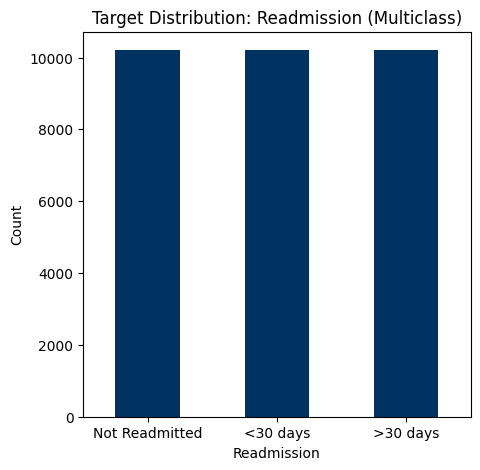

In [14]:
# initialize subplot figure
fig, axs = plt.subplots(1, 1, figsize=(5,5))

# create histogram for ordinal readmission counts column
df_train_m.readmit_ordinal.value_counts().sort_index().plot.bar(ax=axs, rot=0, grid=False, color='#003262')
axs.set_title('Target Distribution: Readmission (Multiclass)')
axs.set_xlabel('Readmission')
axs.set_ylabel('Count')
axs.set_xticks([0,1,2],labels=('Not Readmitted','<30 days','>30 days'))


plt.show()

In [16]:
# Readmitted proportions
readmit_prop = df_train_m['readmit_ordinal'].value_counts(normalize=True)
readmit_prop

0   0.33
1   0.33
2   0.33
Name: readmit_ordinal, dtype: float64

##### 4.1.2: Features

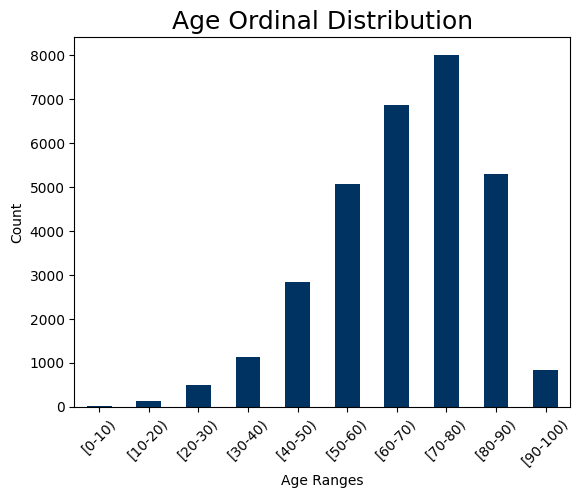

In [23]:
ax = X_train_m.age_ordinal.value_counts().sort_index().plot(kind='bar', x='age_ordinal', color='#003262')

# apply manual bar labels
age_dict = {'[0-10)': 1,'[10-20)': 2,'[20-30)': 3, '[30-40)': 4, '[40-50)': 5, '[50-60)': 6, '[60-70)': 7, '[70-80)': 8, '[80-90)': 9, '[90-100)': 10}
feature_bar_labels = list(age_dict.keys())
ax.set_xticklabels(feature_bar_labels)

plt.title('Age Ordinal Distribution', fontsize=18)
plt.xlabel('Age Ranges')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

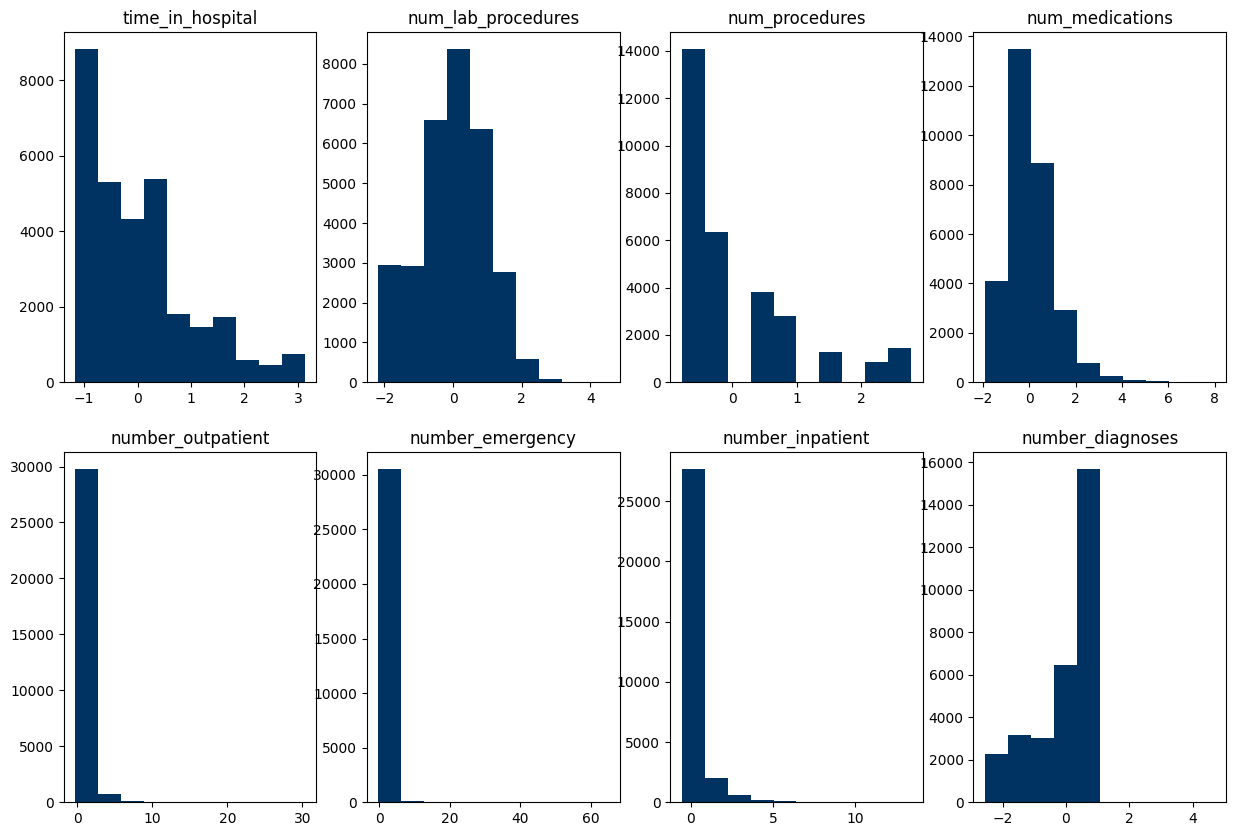

In [18]:
# non-ordinal (numeric) histograms of interest
cols_of_interest = ['time_in_hospital','num_lab_procedures','num_procedures',
                    'num_medications', 'number_outpatient', 'number_emergency',
                    'number_inpatient', 'number_diagnoses']

# generate subplots
fig, axs = plt.subplots(2, 4, figsize=(15,10))
for idx, axis in enumerate(axs.flatten()):
    if idx == (len(axs.flatten())):
        break
    axis.hist(x=df_train_m[cols_of_interest[idx]], color='#003262')
    axis.set_title(cols_of_interest[idx])

plt.show()

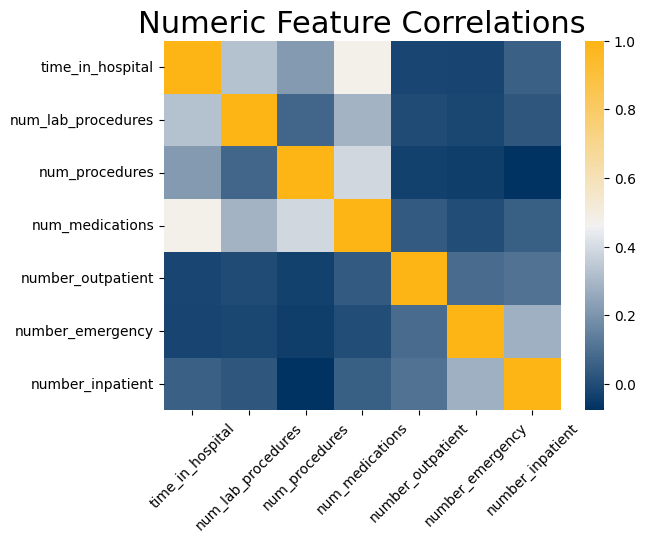

In [28]:
# Create a color map with the berkeley colors
pos_color = sns.light_palette('#003262', as_cmap=True).reversed()
neg_color = sns.light_palette('#FDB515', as_cmap=True)

# combine the two colors into a list
newcolors = np.vstack((pos_color(np.linspace(0, 1, 128)),
                       neg_color(np.linspace(0, 1, 128))))

# create variable and colormap from list of cmaps above
mymap = LinearSegmentedColormap.from_list('my_colormap', newcolors)

# list the numeric features of interest
corr_mat_features = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient']

# generate correlation matrix from features of interest
corr_mat = df_train_m[corr_mat_features].corr()

# plot heatmap and format
sns.heatmap(corr_mat, cmap=mymap)
plt.xticks(rotation = 45)
plt.title('Numeric Feature Correlations', fontsize=22)
plt.show()

#### 4.2: Binary

##### 4.2.1: Target

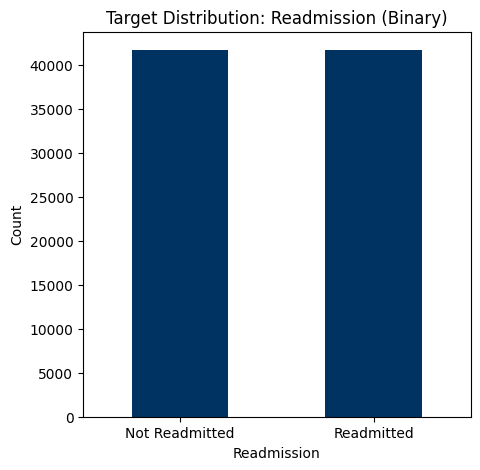

In [30]:
# initialize subplot figure
fig, axs = plt.subplots(1, 1, figsize=(5,5))

# create histogram for binary readmission counts column
df_train_b.readmit_binary.value_counts().sort_index().plot.bar(ax=axs, rot=0, grid=False, color='#003262')
axs.set_title('Target Distribution: Readmission (Binary)')
axs.set_xlabel('Readmission')
axs.set_ylabel('Count')
axs.set_xticks([0,1],labels=('Not Readmitted','Readmitted'))

plt.show()

In [31]:
# Readmitted proportions
readmit_prop_b = df_train_b['readmit_binary'].value_counts(normalize=True)
readmit_prop_b

0   0.50
1   0.50
Name: readmit_binary, dtype: float64

##### 4.2.2 Features

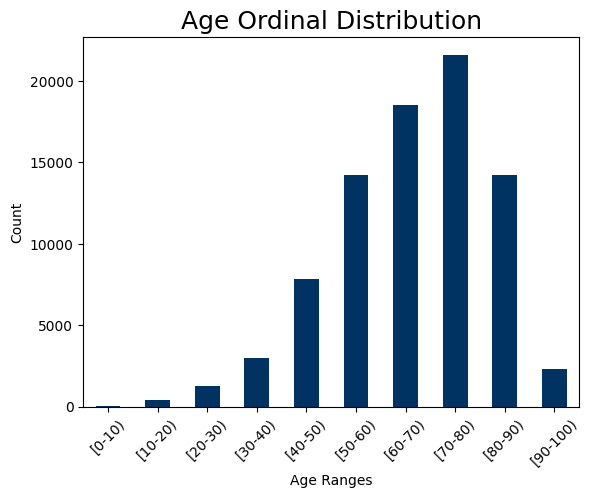

In [32]:
ax = X_train_b.age_ordinal.value_counts().sort_index().plot(kind='bar', x='age_ordinal', color='#003262')

# apply manual bar labels
age_dict = {'[0-10)': 1,'[10-20)': 2,'[20-30)': 3, '[30-40)': 4, '[40-50)': 5, '[50-60)': 6, '[60-70)': 7, '[70-80)': 8, '[80-90)': 9, '[90-100)': 10}
feature_bar_labels = list(age_dict.keys())
ax.set_xticklabels(feature_bar_labels)

plt.title('Age Ordinal Distribution', fontsize=18)
plt.xlabel('Age Ranges')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()

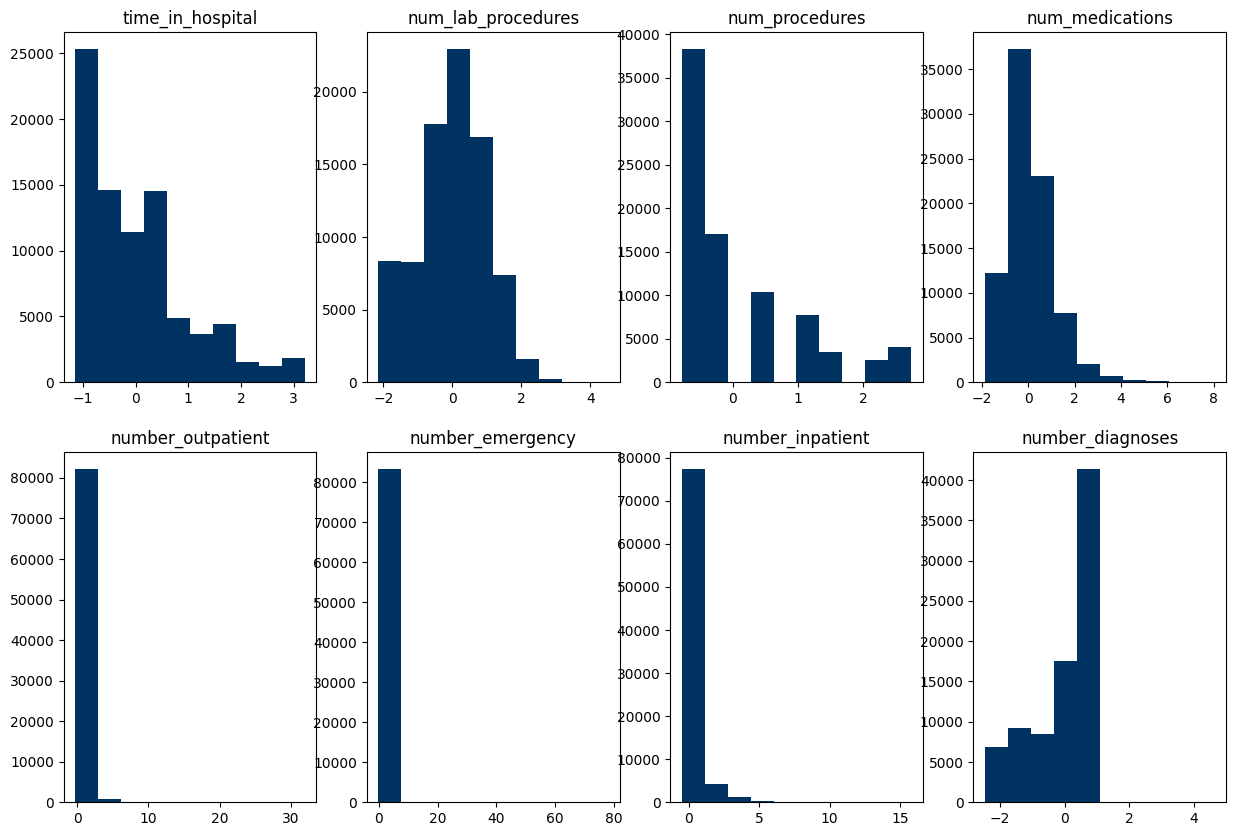

In [33]:
# non-ordinal (numeric) histograms of interest
cols_of_interest = ['time_in_hospital','num_lab_procedures','num_procedures',
                    'num_medications', 'number_outpatient', 'number_emergency',
                    'number_inpatient', 'number_diagnoses']

# generate subplots
fig, axs = plt.subplots(2, 4, figsize=(15,10))
for idx, axis in enumerate(axs.flatten()):
    if idx == (len(axs.flatten())):
        break
    axis.hist(x=df_train_b[cols_of_interest[idx]], color='#003262')
    axis.set_title(cols_of_interest[idx])

plt.show()

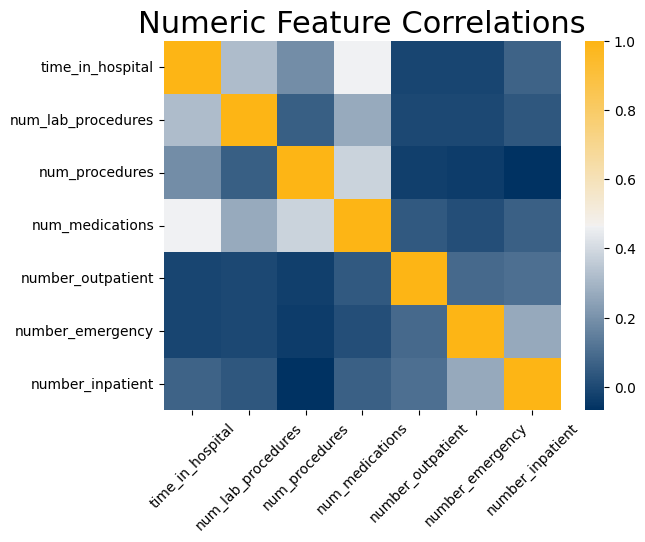

In [34]:
# Create a color map with the berkeley colors
pos_color = sns.light_palette('#003262', as_cmap=True).reversed()
neg_color = sns.light_palette('#FDB515', as_cmap=True)

# combine the two colors into a list
newcolors = np.vstack((pos_color(np.linspace(0, 1, 128)),
                       neg_color(np.linspace(0, 1, 128))))

# create variable and colormap from list of cmaps above
mymap = LinearSegmentedColormap.from_list('my_colormap', newcolors)

# list the numeric features of interest
corr_mat_features = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient']

# generate correlation matrix from features of interest
corr_mat = df_train_b[corr_mat_features].corr()

# plot heatmap and format
sns.heatmap(corr_mat, cmap=mymap)
plt.xticks(rotation = 45)
plt.title('Numeric Feature Correlations', fontsize=22)
plt.show()